# Calculate generation times

## Idea

Make a dilution series and let them grow head-to-head. The generation time can be calculated by the interval the diluted series are behind the less diluted ones. E.g. by dilution factor 10, the shift in x-axis (time) equals a growth by factor 10 (which is log2(10)=3.3219... generations).

$$ t_\text{generation} = \frac{\Delta t}{\log_2 10} \approx \frac{\Delta t}{3.3219}$$

In [133]:
# Import statements

import numpy as np #math
from scipy.optimize import curve_fit # fitting curve
import pandas as pd # DataFrame

import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting

from import_Tecan import * # own module import_Tecan with auxilary code to read Tecan xlsx files 

In [134]:
# Parameters

#filename = "2024-01-25_Generationszeiten1und2zusammen.xlsx"
filename = "2024-02-21_Generationszeiten_B.spiz.ancestor.xlsx"

well = "C3" # well to print for single well exploration
#window_size = 30
OD_threshold = 0.55 # which OD is considered to set the timepoints for interval computation

#### columns 1, 5 of the well are the baseline, columns 2 and 6 10-fold diluted, 3 and 7 100-fold and 4, 8 1000-fold

In [135]:
# Manual import
# Reading csv, handcrafted from Tecan software

## give filename, delimiter ("\t" for Tab, "," for comma, or ";" for semicolon), and German decimal delimiter ","
## rename and set time as index

#df_OD_reads_old = pd.read_csv("all_ODs.csv", sep="\t", decimal=",").rename(columns={"Time [s]": "time"}).set_index('time')

In [136]:
# Importing xlsx using import_Tecan.py
df_OD_reads = import_Tecan_xlsx(filename)
df_OD_reads.head()

A1      A2      A3      A4      A5      A6      A7      A8  \
time in s                                                                   
0.0        0.2570  0.1012  0.0870  0.0852  0.2636  0.0994  0.0865  0.0848   
95.3       0.2559  0.1011  0.0869  0.0850  0.2642  0.0999  0.0861  0.0848   
190.6      0.2553  0.1013  0.0869  0.0850  0.2592  0.0998  0.0861  0.0847   
285.9      0.2567  0.1011  0.0892  0.0858  0.2593  0.1007  0.0867  0.0847   
381.2      0.2571  0.1016  0.0897  0.0855  0.2605  0.1011  0.0861  0.0848   

               A9     A10  ...      H3      H4      H5      H6      H7  \
time in s                  ...                                           
0.0        0.2574  0.1029  ...  0.0878  0.0860  0.2617  0.1016  0.0876   
95.3       0.2585  0.1028  ...  0.0875  0.0897  0.2671  0.1017  0.0876   
190.6      0.2586  0.1027  ...  0.0877  0.0896  0.2713  0.1046  0.0877   
285.9      0.2611  0.1028  ...  0.0878  0.0886  0.2730  0.1016  0.0876   
381.2      0.2610  0.1029  ...  0.0880  0.0882  0.2722  0.1068  0.0909   

               H8      H9     H10     H11     H12  
time in s                                          
0.0        0.0860  0.2566  0.1057  0.0879  0.0858  
95.3       0.0855  0.2621  0.1060  0.0882  0.0857  
190.6      0.0856  0.2639  0.1060  0.0880  0.0859  
285.9      0.0854  0.2615  0.1060  0.0882  0.0857  
381.2      0.0865  0.2629  0.1066  0.0882  0.0858  

[5 rows x 96 columns]

In [137]:
#df_index = df_OD_reads.set_index('Time [s]')

# Melt the DataFrame to make it suitable for Seaborn
#
# df_melted = df_index.reset_index().melt('Time [s]', var_name='well', value_name='OD')

# Create the lineplot
#sns.lineplot(x='Time [s]', y='OD', hue='well', data=df_melted, legend=False)

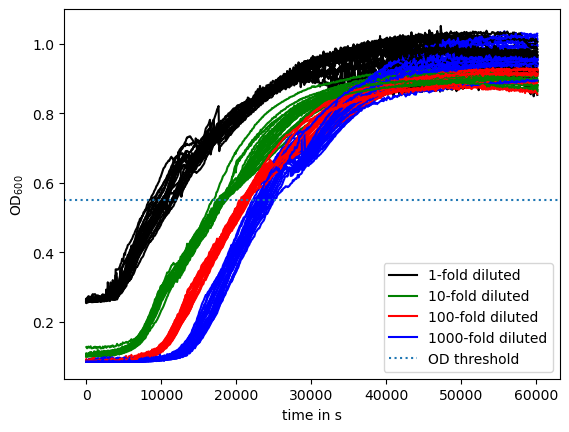

In [138]:
# Define wells and dilutions

# then plot all
# Plot each column

dilutions = { # store wells according to their respective dilution factor
    1: [],
    10: [],
    100: [],
    1000: []
}

plot_colors = {1: "black", 10: "green", 100: "red", 1000: "blue", 0: "gray"}

for column in df_OD_reads.columns:
    # match columns and dilutions
    match column[1:]: # look just for number=column in well plate (drop first character = A, B, C, ...)
        case "1" | "5" | "9": temp_dilution = 1 # if column is 1, 5, or 9
        case "2" | "6" | "10": temp_dilution = 10
        case "3" | "7" | "11": temp_dilution = 100
        case "4" | "8" | "12": temp_dilution = 1000
        case _: # Default (none of above)
            print(column[1:], " is not found")
            temp_dilution = 0
    
    dilutions[temp_dilution].append(column) # add to suitable dilutions key
    
    # label just the first encounter to not overlaod legend
    if len(dilutions[temp_dilution]) == 1: temp_label = str(temp_dilution)+"-fold diluted"
    else: temp_label = None
    
    # plot lines with temp_color
    sns.lineplot(data=df_OD_reads, x=df_OD_reads.index, y=column, color = plot_colors[temp_dilution], label=temp_label)
    
# show the chosen threshold
plt.axhline(y=OD_threshold, label = "OD threshold", linestyle = "dotted")

plt.ylabel("$\\text{OD}_{600}$")
plt.legend()

Text(0, 0.5, '$\\text{OD}_{600}$')

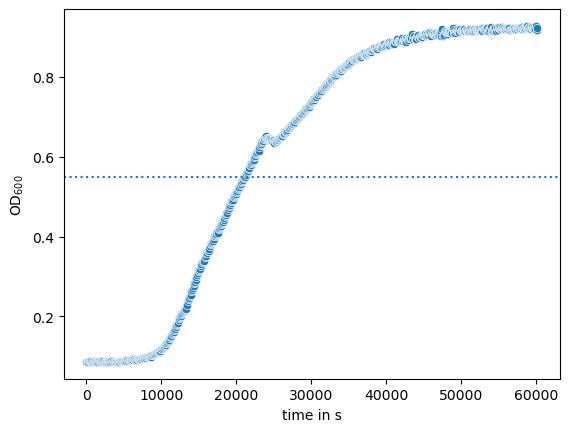

In [139]:
# single well plotting for data exploration
well = "C3"
sns.scatterplot(x=df_OD_reads.index, y = df_OD_reads[well],legend=False)

plt.axhline(y=OD_threshold, label = "OD threshold", linestyle = "dotted")
plt.ylabel("$\\text{OD}_{600}$")

## Fit logistic curve

Logistic function

$$f(x) = \frac{L}{1+e^{{-k(x-x_0)}}}  + \text{offset}$$

$$\Leftrightarrow x = -\frac{\ln(\frac{L}{y-\text{offset}}-1)}{k} + x_0 $$

Exponential function

$$f(x) = A \cdot e^{b \cdot (x-x_0)} + \text{offset}$$

$$\Leftrightarrow x = \frac{\ln(\frac{y-\text{offset}}{A})}{b} + x_0$$

In [140]:
# Define functions for fitting and their inverse

def logisticfunction(x,L,x0,k,offset):
    return L / (1 + np.exp(-k*(x-x0))) + offset

def inverse_logisticfunction(y,L,x0,k,offset):
    return -((np.log(L/(y-offset)-1))/k) + x0


def exponentialfunction(x, A, b, x0, offset):
    return A*np.exp(b*(x-offset)) + offset

def inverseexponentialfunction(y, A, b, x0, offset):
    return np.log((y-offset)/A)/b + x0


# set functions to use
fitfunction = logisticfunction
inverse_fitfunction = inverse_logisticfunction

## Trim data beyond the plateau to make fits possible
Plateau is found by the maximum of the rolling mean and then all data beyond 1-0.3 = 70% of that peak is cut to get a nice curve to fit for.

In [141]:
def trim_curve(df, window_size = None, trim_ratio = 0.3, override_halfheight_check = False, override_monotonicity_check = False, debug = False):
    """Function to trim the DataFrame to the peak of the curve.
    The peak is determined by a rolling window function.
    The DataFrame is trimmed to the peak minus some extra cutoff, determined by the float trim_ratio.
    The function also checks if the maximum value of the returned DataFrame is at least 60% of the
    maximum value of the trimmed DataFrame and it is monotonically increasing when a window=2 rolling mean is applied.

    Args:
        df (DataFrame): DataFrame to be trimmed
        window_size (int, optional): rolling windows size. Defaults to None, then it is determined by the size of the DataFrame/30.
        trim_ratio (float, optional): float for the ratio of trimming. I.e. df is trimmed to [:(1-trim_ratio)*peak_index)]. Defaults to 0.3.
        override_halfheight_check (bool, optional): boolean to override the check if the maximum value of the DataFrame is at least 60% of the maximum value of the trimmed DataFrame. Defaults to False.
        override_monotonicity_check (bool, optional): boolean to override the check if the resulting DataFrame is monotonic under rolling mean. Defaults to False.
        debug (bool, optional): boolean whether to plot the DataFrame and the trimmed DataFrame. Defaults to False.

    Raises:
        ValueError: If the maximum value of the trimmed DataFrame is less than 60% of the maximum value of the input DataFrame.
        ValueError: If the DataFrame is not monotonically increasing under rolling mean.

    Returns:
        DataFrame: Trimmed DataFrame
    """
    
    if not isinstance(window_size, int):
        # dynamic windows_size depending on size of df
        window_size = round(df.shape[0]/30)
    #print(df.shape)
        
    #df['rolling_mean'] = df[well].rolling(window=window_size).mean()

    #max_value = df['rolling_mean'].max()
    #max_index = df['rolling_mean'].idxmax()

    max_index = df.rolling(window=window_size, center = True).mean().idxmax() # We are only interested in the index of the peak
    # use mean to make distribution smoother, `center = True` centers window around index (e.g. index 5 --> mean of 3,4,5,6,7 instead of 5,6,7,8,9) 

    # Identify the dip by finding the next minimum after the max
    #dip_index = df.loc[max_index:]['rolling_mean'].idxmin()
    
    
    trimmed_df = df.loc[:round((1-trim_ratio)*max_index)]
    
    
    if not override_halfheight_check:
        if trimmed_df.max()/df.max() < 0.6:
            raise ValueError("The maximum value of input DataFrame is ", df.max(), " and the maximum of trimmed DataFrame is ", trimmed_df.max(), " which is less than 60%. You can override tihs error by setting override_halfheight_check = True.\n", df.head())
    
    if not override_monotonicity_check:
        if trimmed_df.rolling(window = 2).sum().is_monotonic_increasing:
            raise ValueError("The DataFrame (smoothed with rolling window 5) is not monotonic. You can override tihs error by setting override_monotonicity_check = True.\n df.head()")
    
    # much more comprehensive plotting to find caveats
    if debug:
        print("The peak is found at x=", max_index,"resulting in a trim at x=", round((1-trim_ratio)*max_index))
        fig = plt.figure(figsize=(10,5))
        sns.lineplot(df, label = "input df", linestyle = "dotted")
        sns.lineplot(df.rolling(window=window_size, center = True).mean(), label = "rolling mean")
        sns.lineplot(trimmed_df, label = "trimmed df")
        plt.axvline(x = round((1-trim_ratio)*max_index), label="trim $x$-threshold", color="g", linestyle="dotted")
        plt.axvline(x = max_index, label="peak of rolling mean", color="r", linestyle="dashed")
        x_values = trimmed_df.index
        plt.scatter(trimmed_df.index, trimmed_df,label="data to fit")
        popt, pcov = curve_fit(fitfunction, trimmed_df.index, trimmed_df, p0=[0.8, 10000, 0.0001,0.4])
        plt.plot(x_values, fitfunction(x_values, *popt), "r-",label="fitted function")
        temp_x = inverse_fitfunction(OD_threshold, *popt)
        xmin = fig.gca().get_xlim()[0]
        ymin = fig.gca().get_ylim()[0]
        plt.hlines(y = OD_threshold, xmin = xmin, xmax = temp_x, color = "grey", linestyle = "dashdot", label = "OD threshold")
        plt.vlines(x = temp_x, ymin = ymin, ymax = OD_threshold, color = "grey", linestyle = "dashdot") # label = "OD threshold"
        plt.legend()
        plt.xlim(xmin)
        plt.ylim(ymin)
        plt.show()


    # return filtered values that are beyond the maximum
    return trimmed_df

The peak is found at x= 46608.3 resulting in a trim at x= 32626


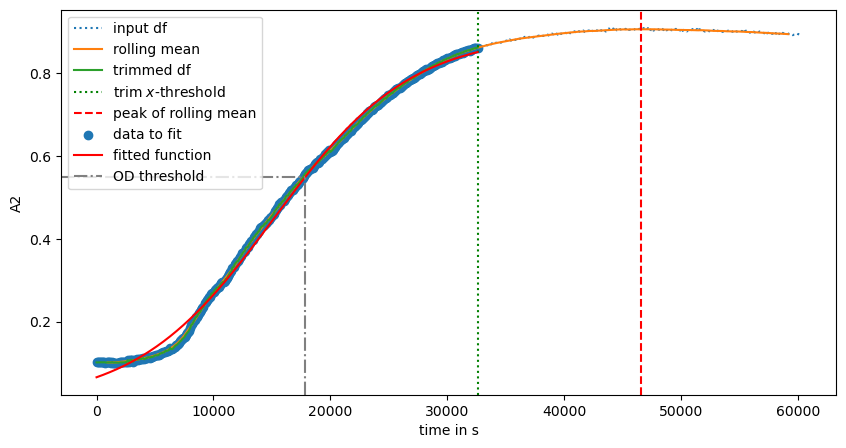

In [142]:
test = trim_curve(df_OD_reads["A2"], debug=True)

## Fit all wells and store parameters

Testing trim and fit for A1
The peak is found at x= 54328.5 resulting in a trim at x= 32597


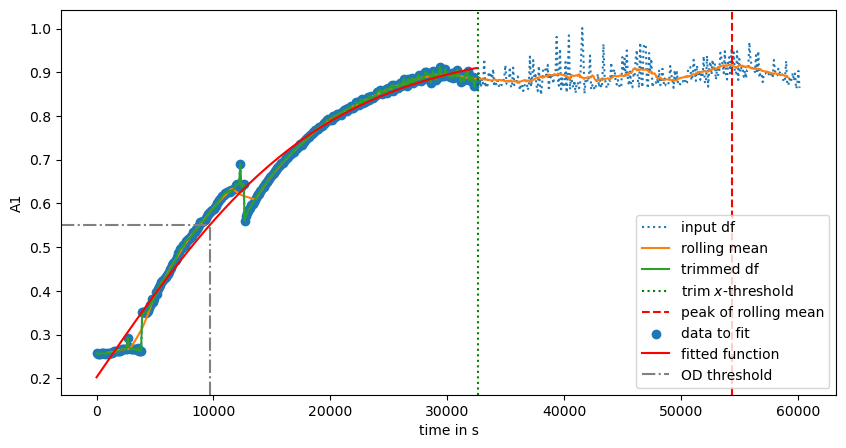

Testing trim and fit for A2
The peak is found at x= 46608.3 resulting in a trim at x= 27965


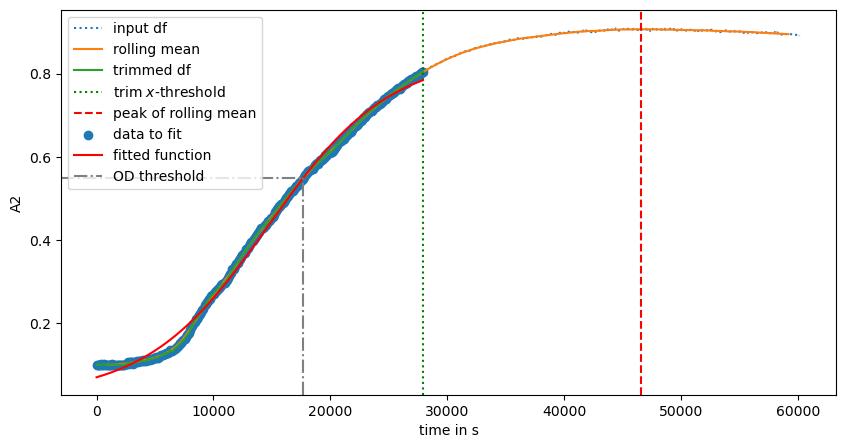

Testing trim and fit for A3
The peak is found at x= 58998.8 resulting in a trim at x= 35399


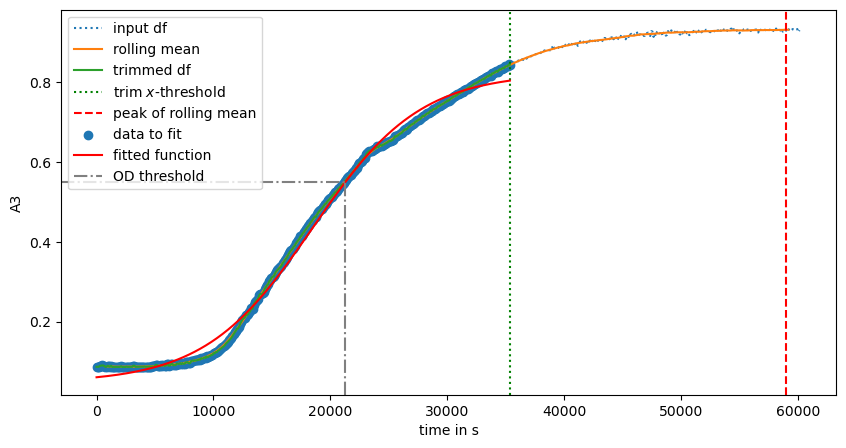

Testing trim and fit for A4
The peak is found at x= 54614.4 resulting in a trim at x= 32769


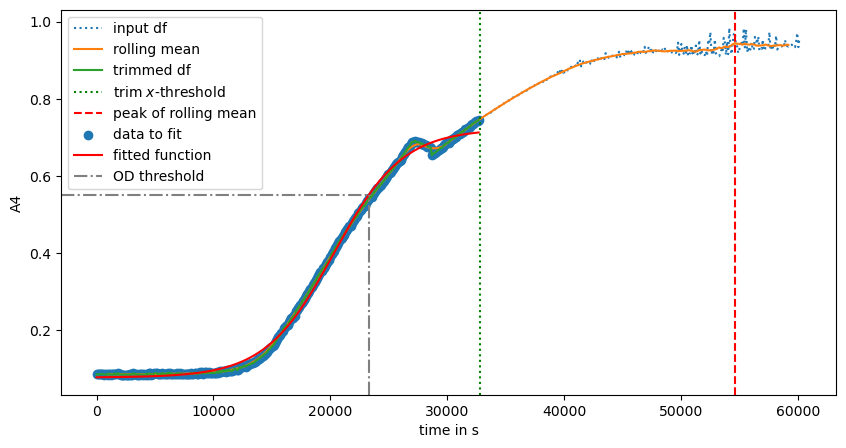

Testing trim and fit for A5
The peak is found at x= 47561.4 resulting in a trim at x= 28537


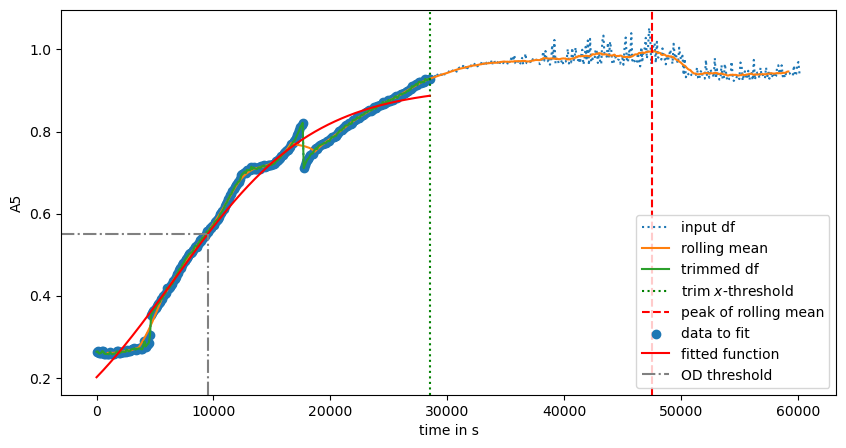

Testing trim and fit for A6
The peak is found at x= 49658.3 resulting in a trim at x= 29795


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2252252516.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, trimmed_df.index, trimmed_df, p0=[0.8, 10000, 0.0001,0.4])


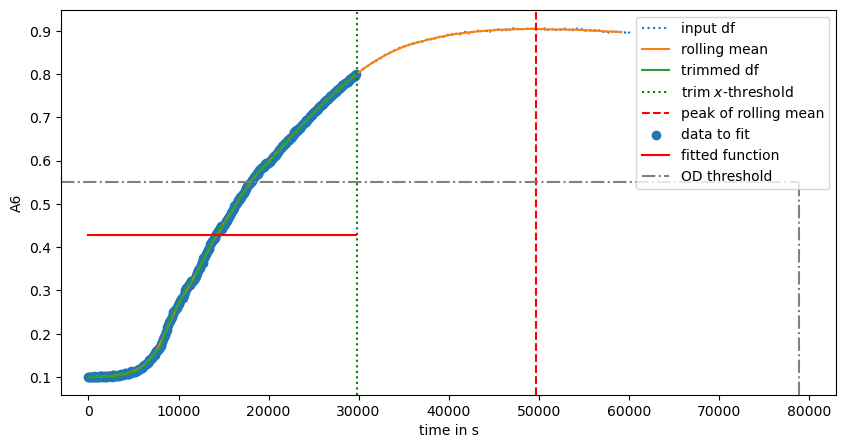

Testing trim and fit for A7
The peak is found at x= 59189.4 resulting in a trim at x= 35514


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2385039485.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, data_to_plot.index, data_to_plot, p0=[0.8, 10000, 0.0001,0.4])


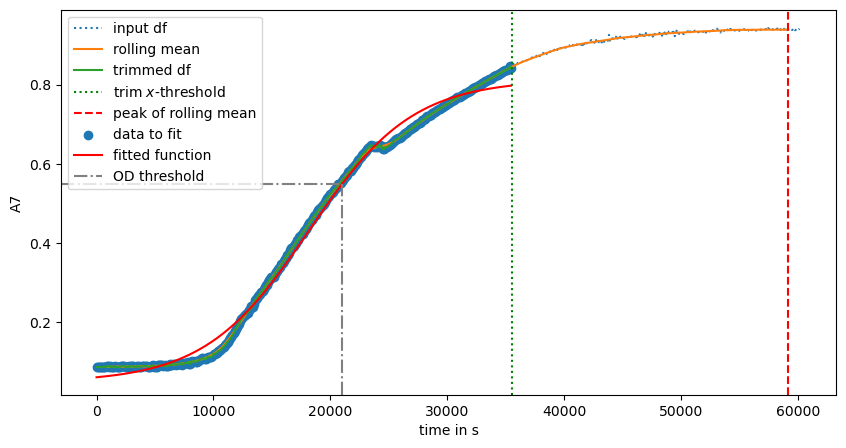

Testing trim and fit for A8
The peak is found at x= 59189.4 resulting in a trim at x= 35514


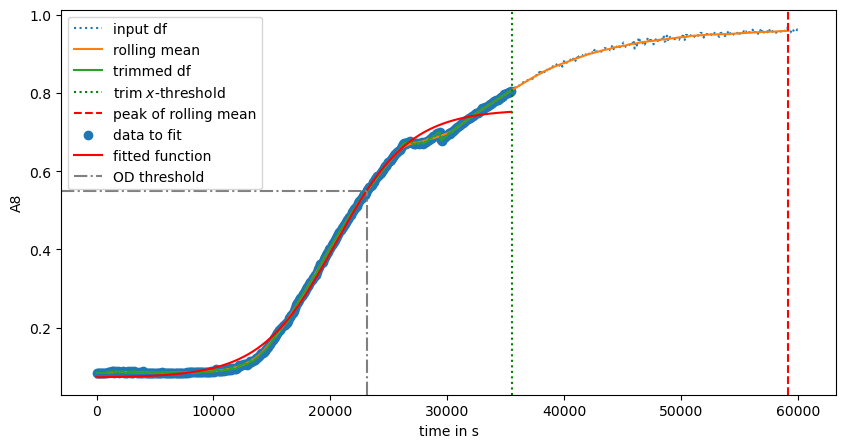

Testing trim and fit for A9
The peak is found at x= 45274.0 resulting in a trim at x= 27164


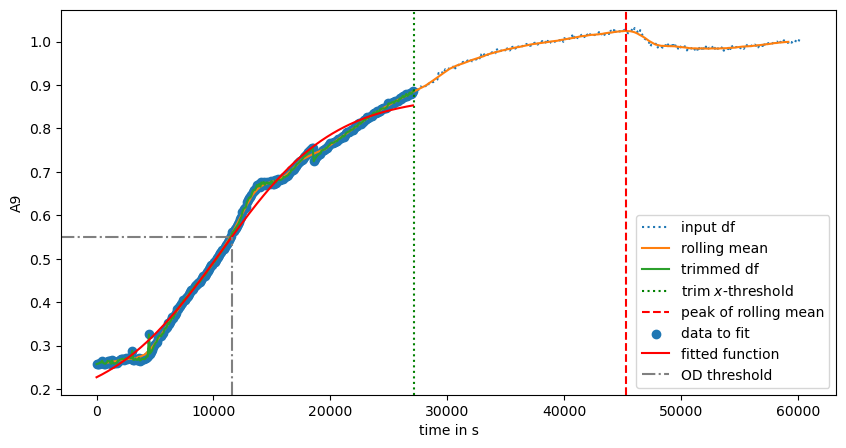

Testing trim and fit for A10
The peak is found at x= 46322.4 resulting in a trim at x= 27793


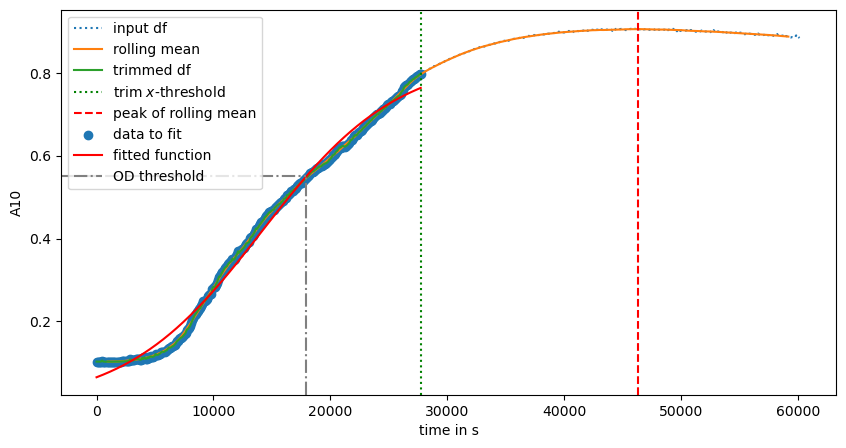

Testing trim and fit for A11
The peak is found at x= 58998.8 resulting in a trim at x= 35399


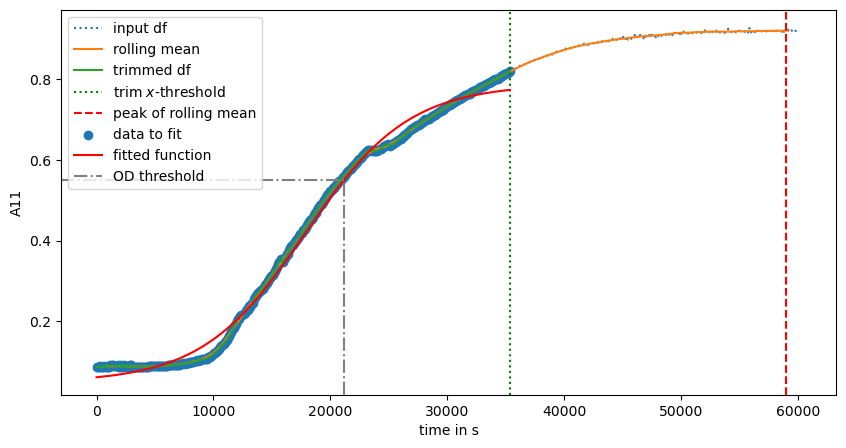

Testing trim and fit for A12
The peak is found at x= 58617.6 resulting in a trim at x= 35171


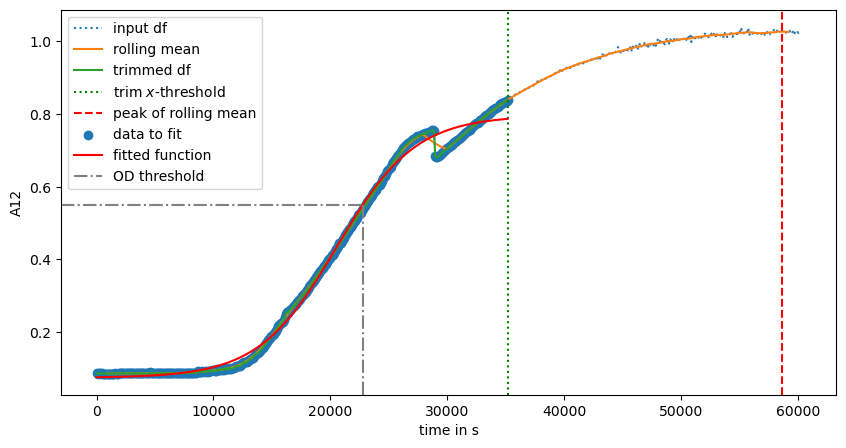

Testing trim and fit for B1
The peak is found at x= 33455.1 resulting in a trim at x= 20073


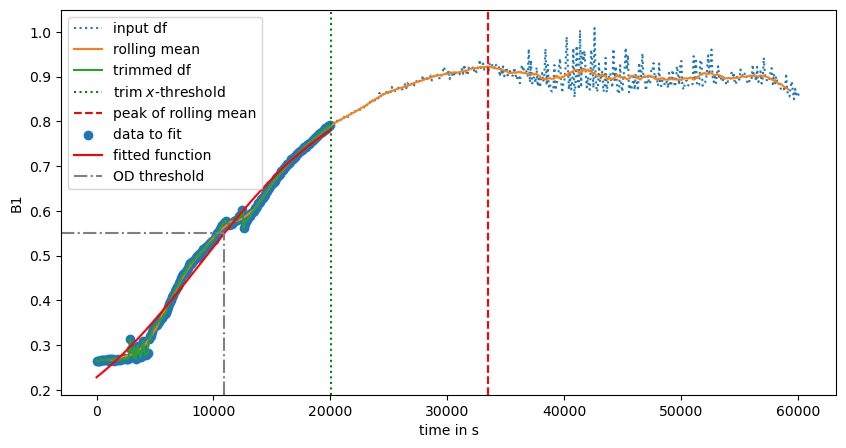

Testing trim and fit for B2
The peak is found at x= 46513.0 resulting in a trim at x= 27908


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2252252516.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, trimmed_df.index, trimmed_df, p0=[0.8, 10000, 0.0001,0.4])


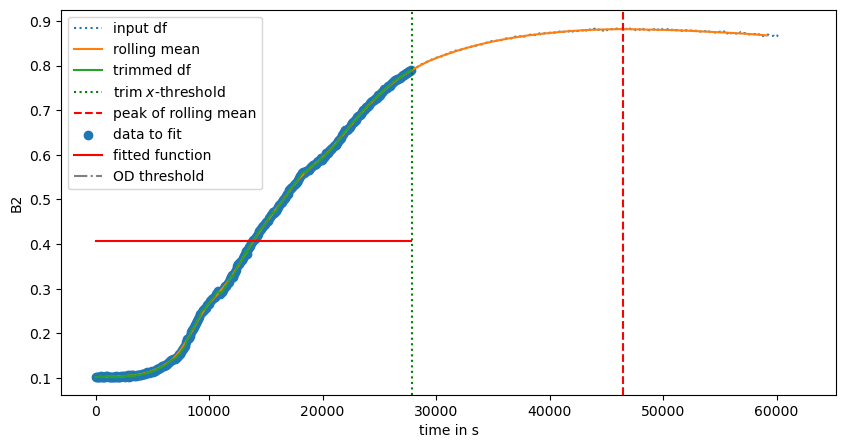

Testing trim and fit for B3
The peak is found at x= 58903.5 resulting in a trim at x= 35342


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2385039485.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, data_to_plot.index, data_to_plot, p0=[0.8, 10000, 0.0001,0.4])


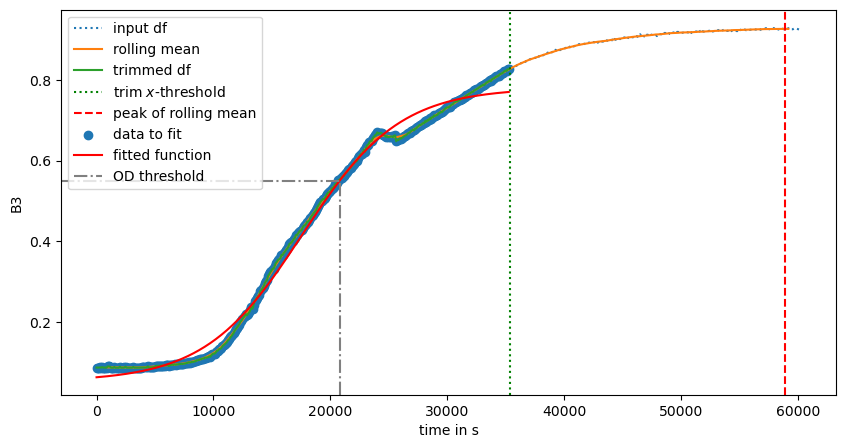

Testing trim and fit for B4
The peak is found at x= 59189.4 resulting in a trim at x= 35514


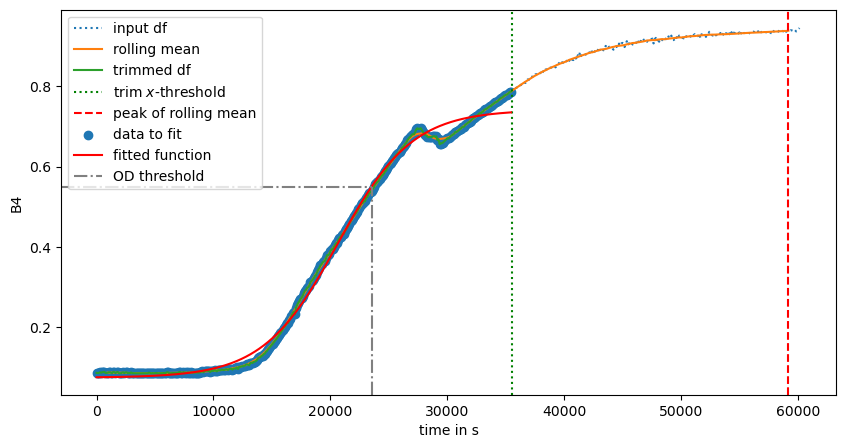

Testing trim and fit for B5
The peak is found at x= 48514.5 resulting in a trim at x= 29109


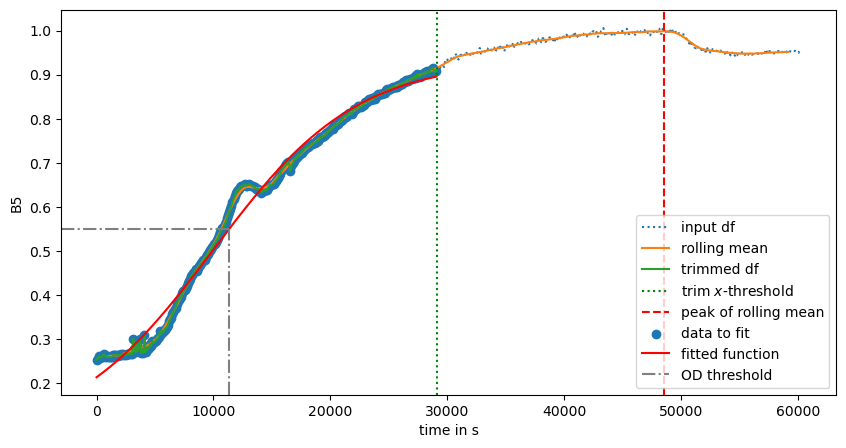

Testing trim and fit for B6
The peak is found at x= 49848.9 resulting in a trim at x= 29909


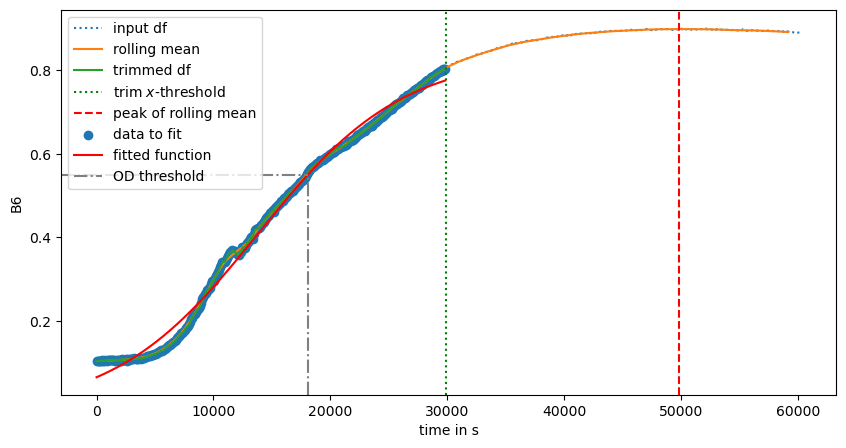

Testing trim and fit for B7
The peak is found at x= 59094.1 resulting in a trim at x= 35456


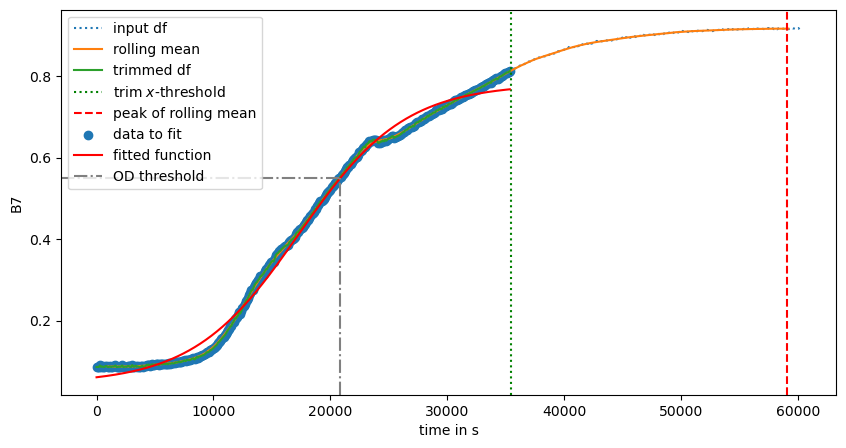

Testing trim and fit for B8
The peak is found at x= 59189.4 resulting in a trim at x= 35514


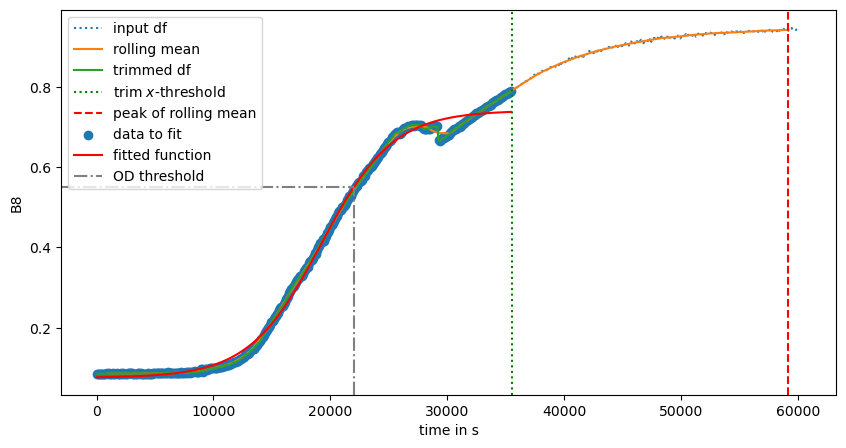

Testing trim and fit for B9
The peak is found at x= 46322.4 resulting in a trim at x= 27793


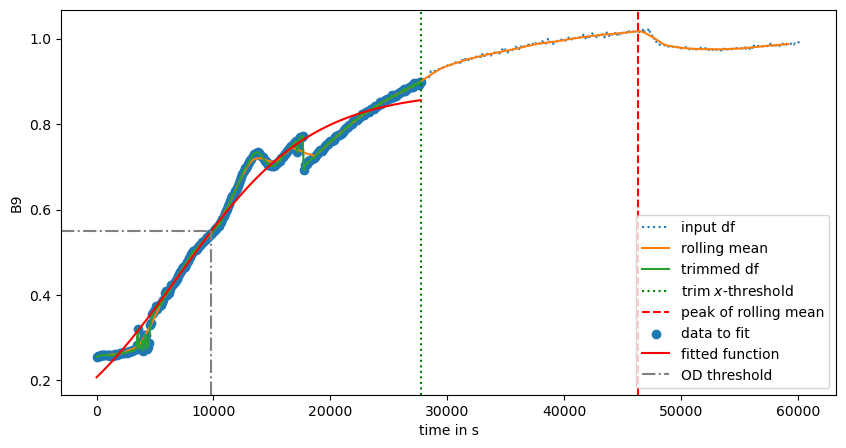

Testing trim and fit for B10
The peak is found at x= 52231.6 resulting in a trim at x= 31339


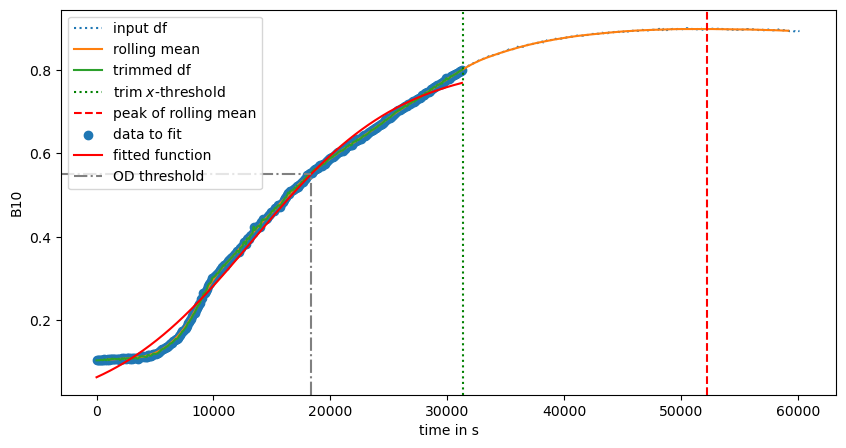

Testing trim and fit for B11
The peak is found at x= 59189.4 resulting in a trim at x= 35514


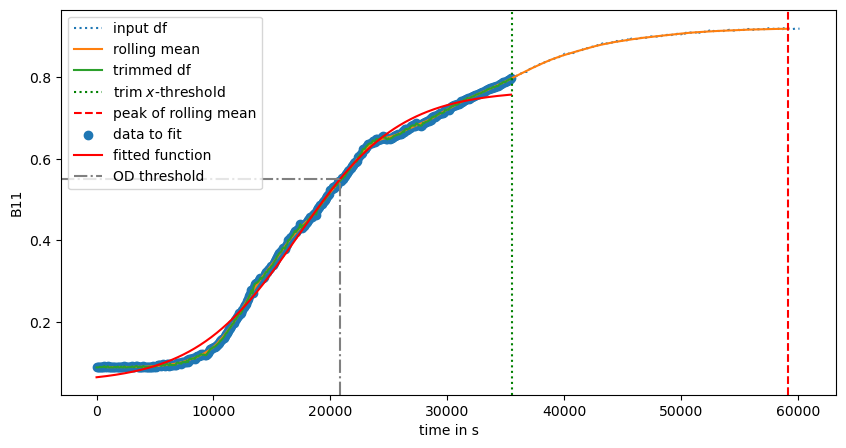

Testing trim and fit for B12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


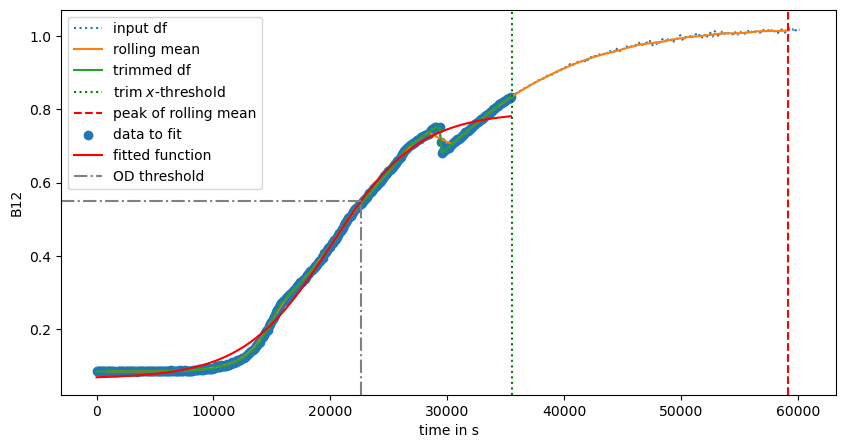

Testing trim and fit for C1
The peak is found at x= 42223.7 resulting in a trim at x= 25334


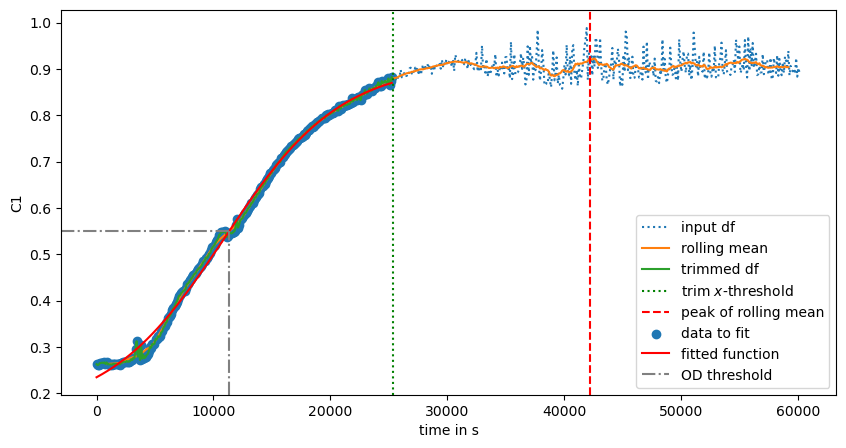

Testing trim and fit for C2
The peak is found at x= 48609.8 resulting in a trim at x= 29166


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2252252516.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, trimmed_df.index, trimmed_df, p0=[0.8, 10000, 0.0001,0.4])


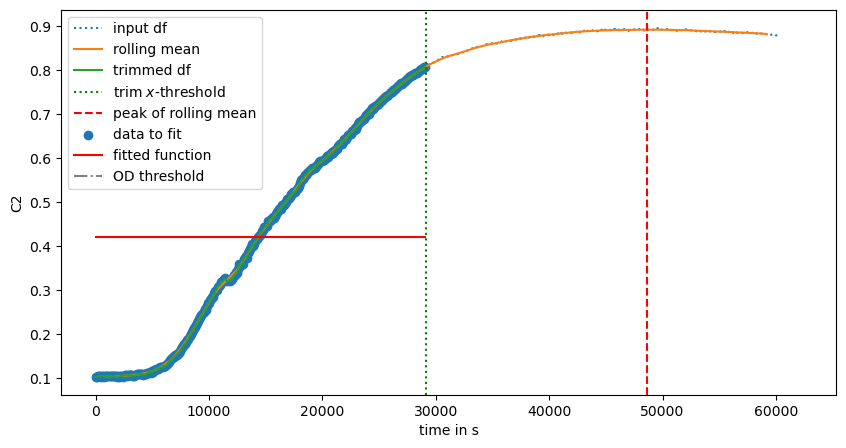

Testing trim and fit for C3
The peak is found at x= 58712.9 resulting in a trim at x= 35228


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2385039485.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, data_to_plot.index, data_to_plot, p0=[0.8, 10000, 0.0001,0.4])


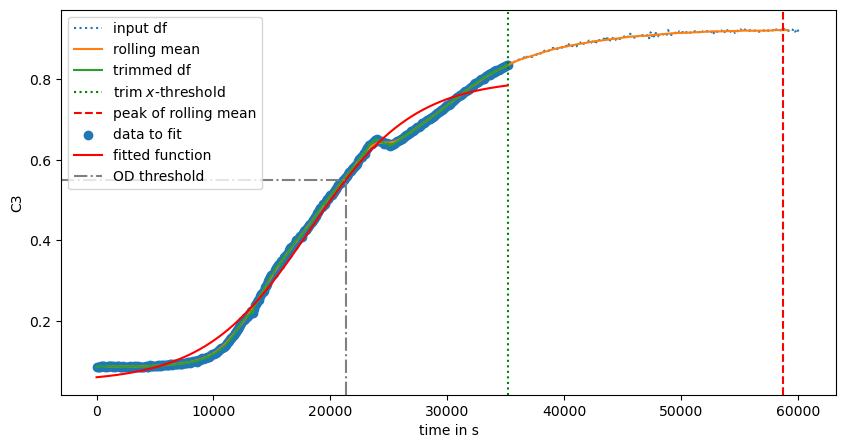

Testing trim and fit for C4
The peak is found at x= 59189.4 resulting in a trim at x= 35514


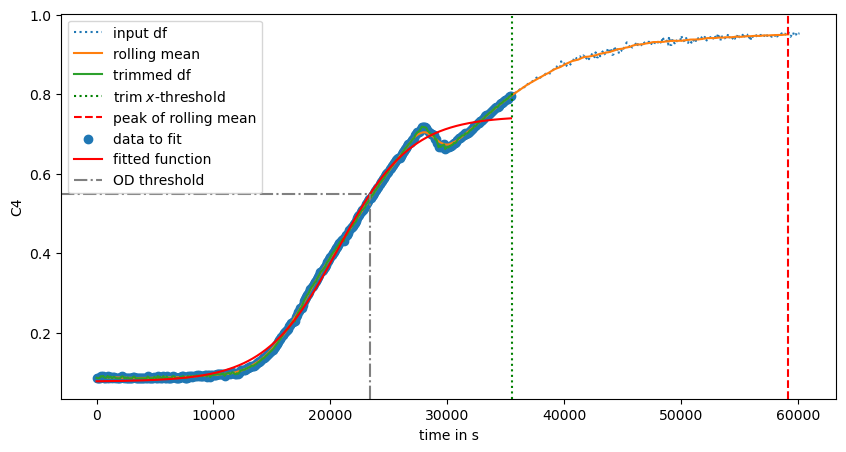

Testing trim and fit for C5
The peak is found at x= 48323.9 resulting in a trim at x= 28994


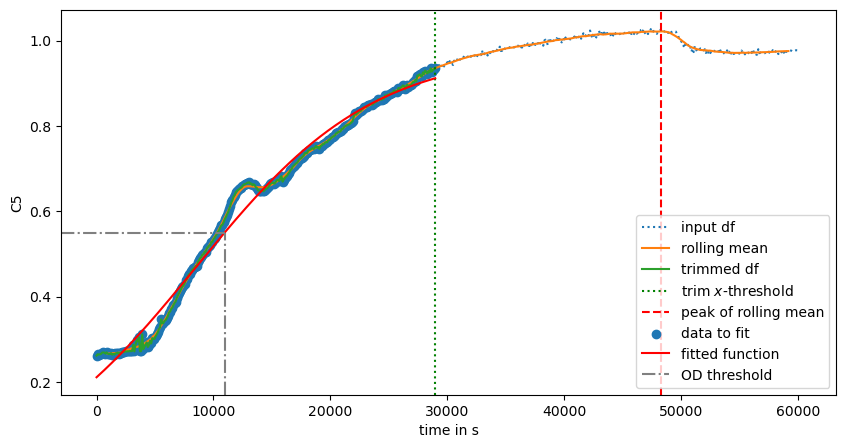

Testing trim and fit for C6
The peak is found at x= 52994.1 resulting in a trim at x= 31796


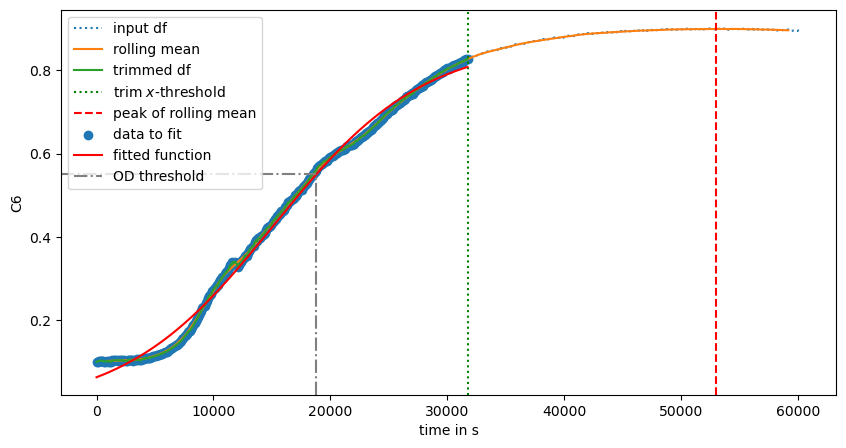

Testing trim and fit for C7
The peak is found at x= 58998.8 resulting in a trim at x= 35399


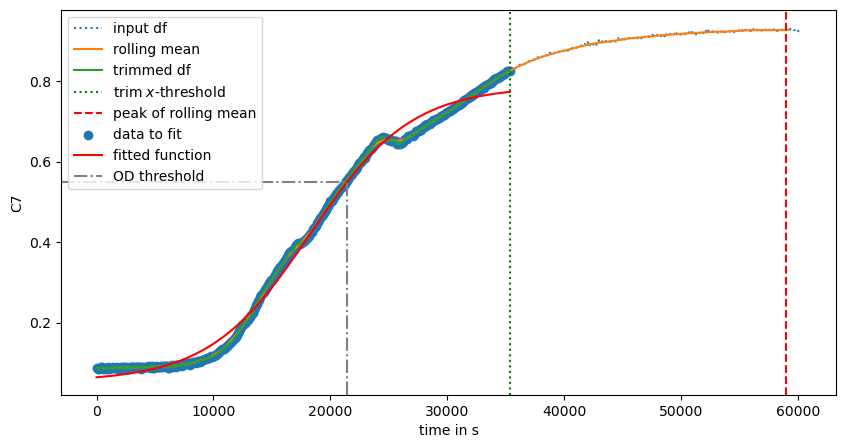

Testing trim and fit for C8
The peak is found at x= 58426.8 resulting in a trim at x= 35056


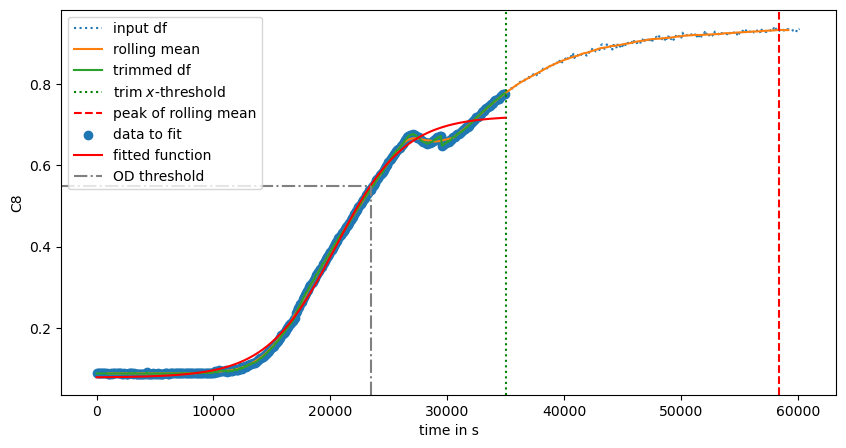

Testing trim and fit for C9
The peak is found at x= 46989.5 resulting in a trim at x= 28194


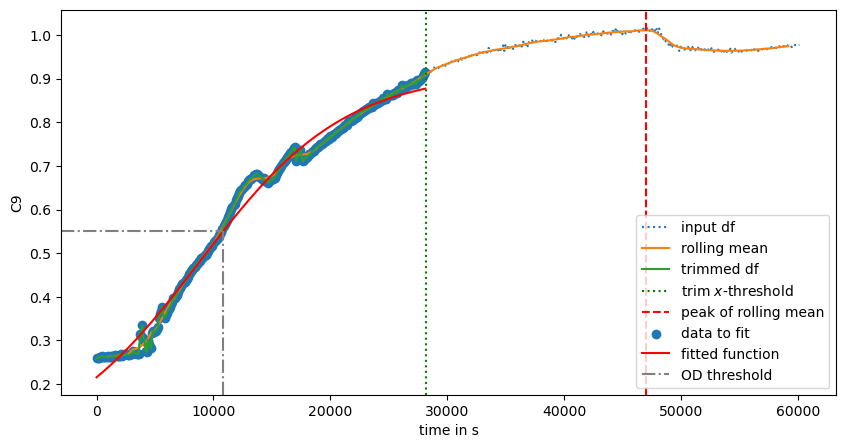

Testing trim and fit for C10
The peak is found at x= 51564.5 resulting in a trim at x= 30939


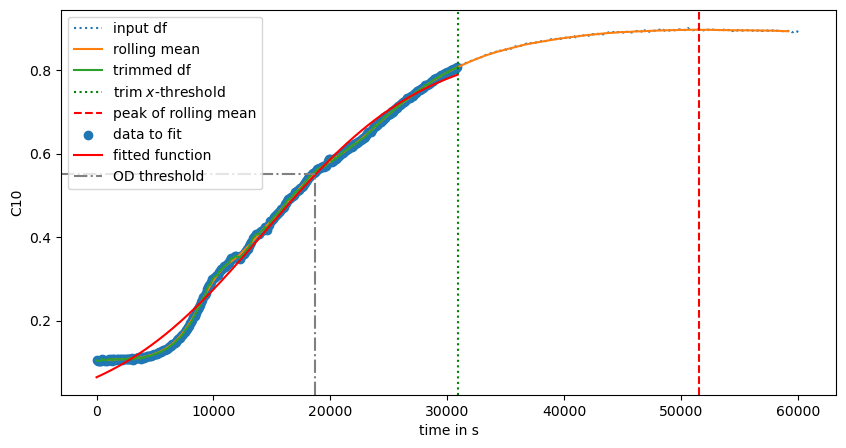

Testing trim and fit for C11
The peak is found at x= 59189.4 resulting in a trim at x= 35514


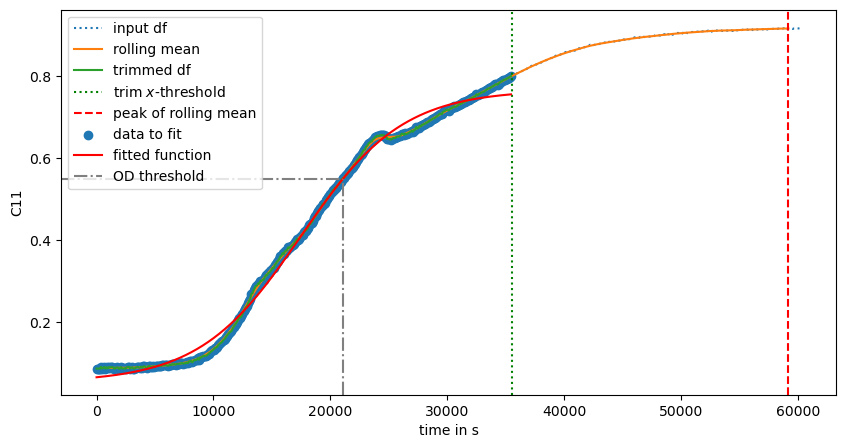

Testing trim and fit for C12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


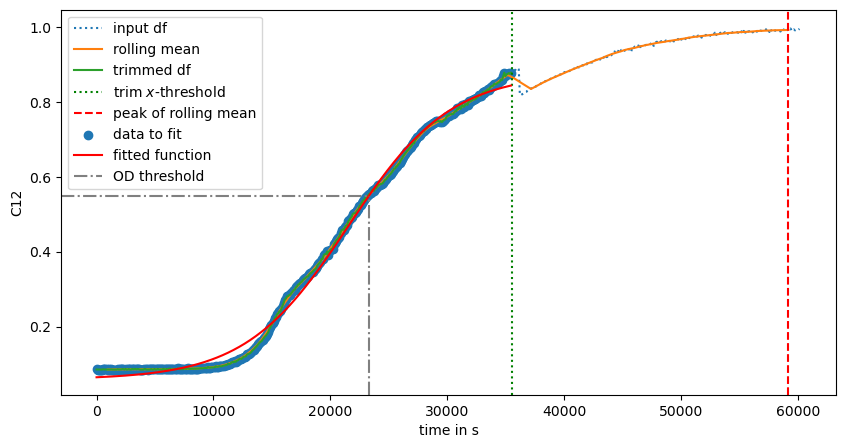

Testing trim and fit for D1
The peak is found at x= 41937.7 resulting in a trim at x= 25163


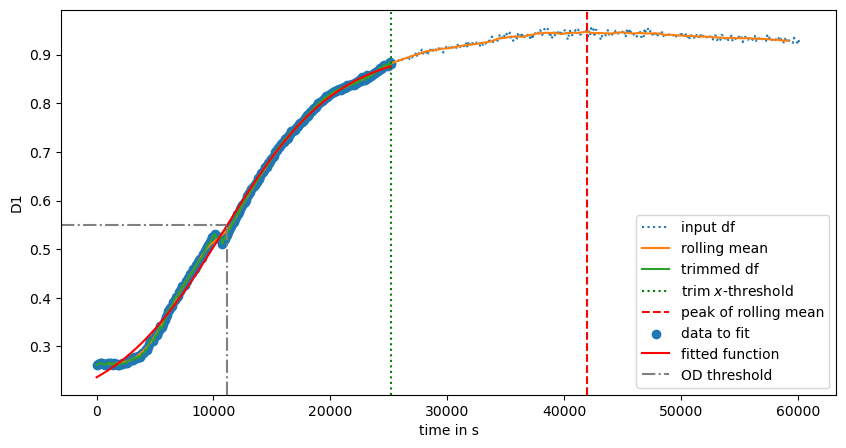

Testing trim and fit for D2
The peak is found at x= 46322.4 resulting in a trim at x= 27793


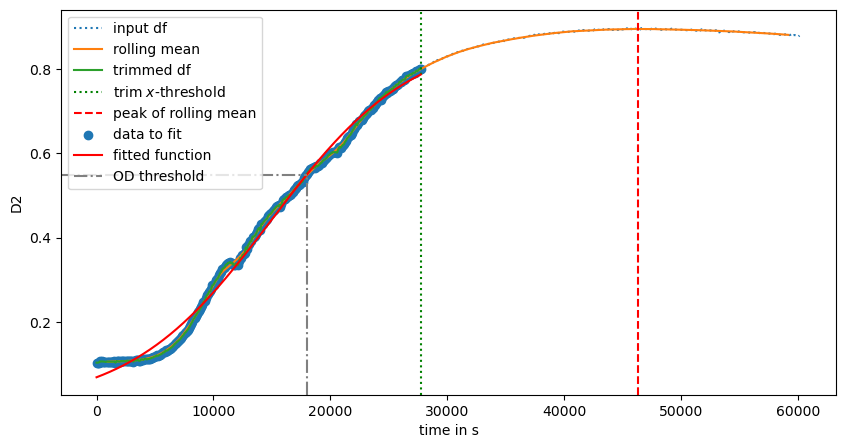

Testing trim and fit for D3
The peak is found at x= 56615.9 resulting in a trim at x= 33970


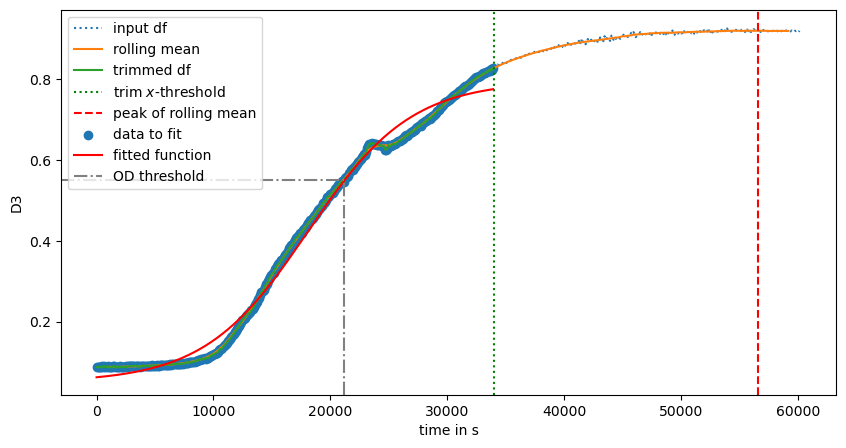

Testing trim and fit for D4
The peak is found at x= 59094.1 resulting in a trim at x= 35456


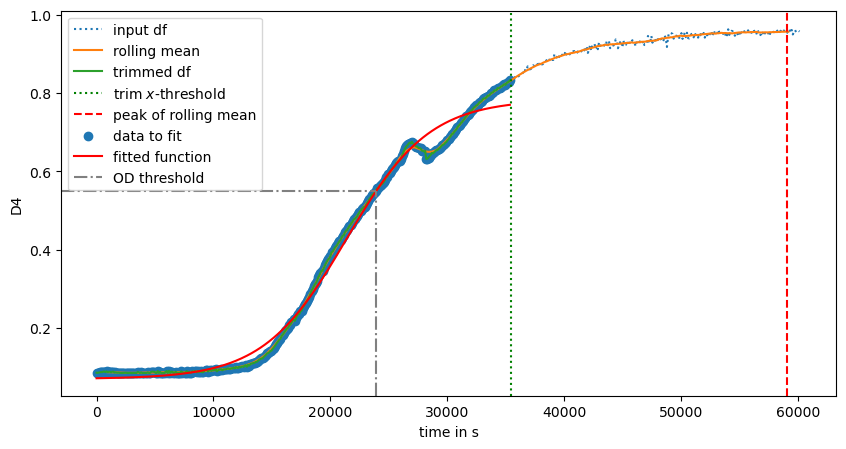

Testing trim and fit for D5
The peak is found at x= 47656.7 resulting in a trim at x= 28594


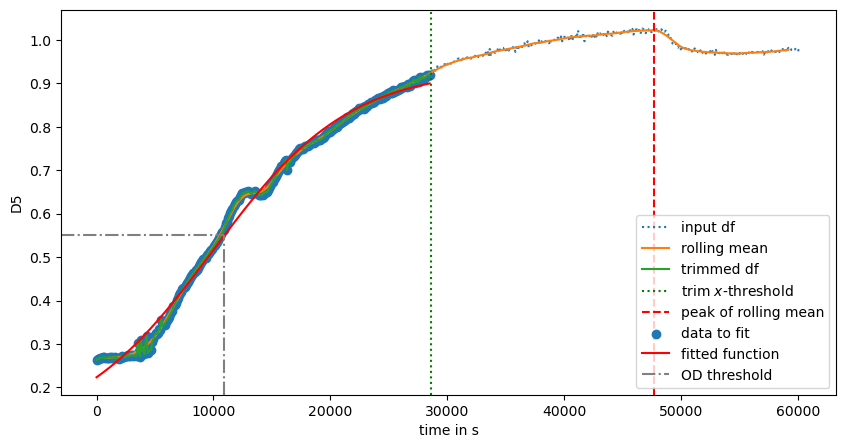

Testing trim and fit for D6
The peak is found at x= 52612.9 resulting in a trim at x= 31568


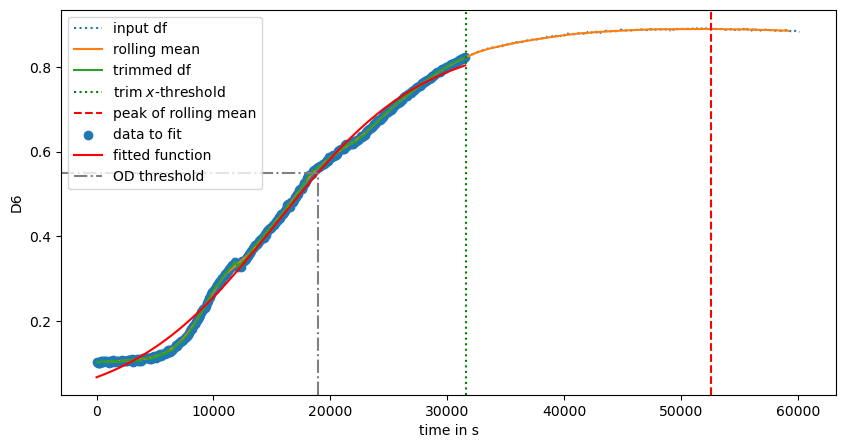

Testing trim and fit for D7
The peak is found at x= 59094.1 resulting in a trim at x= 35456


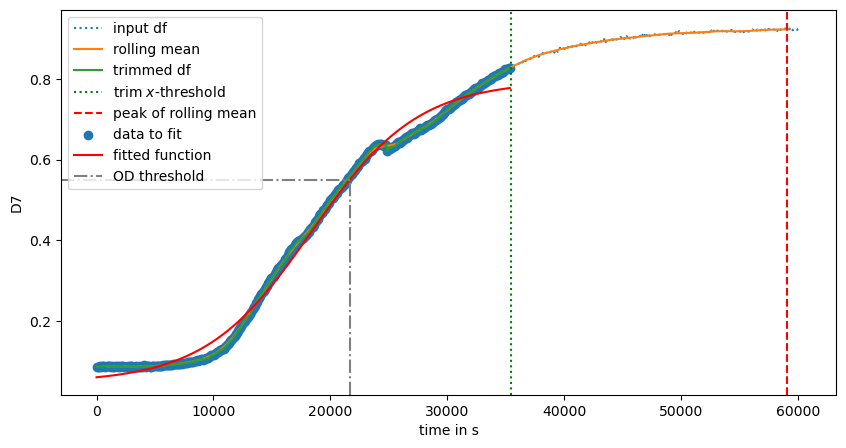

Testing trim and fit for D8
The peak is found at x= 59094.1 resulting in a trim at x= 35456


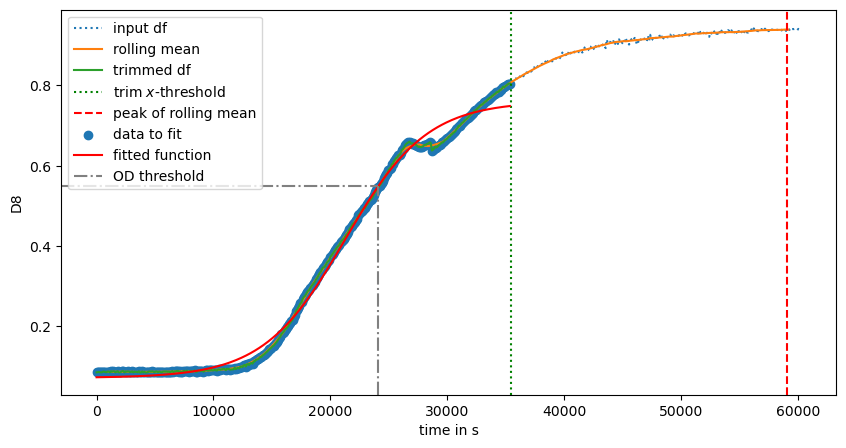

Testing trim and fit for D9
The peak is found at x= 46131.8 resulting in a trim at x= 27679


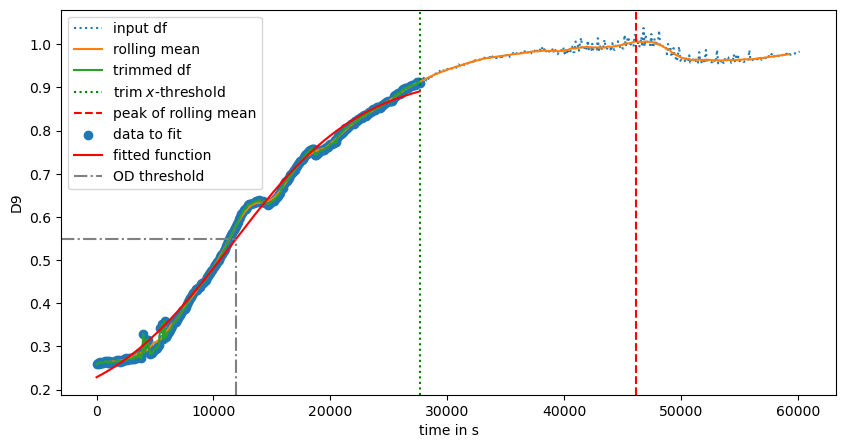

Testing trim and fit for D10
The peak is found at x= 52327.0 resulting in a trim at x= 31396


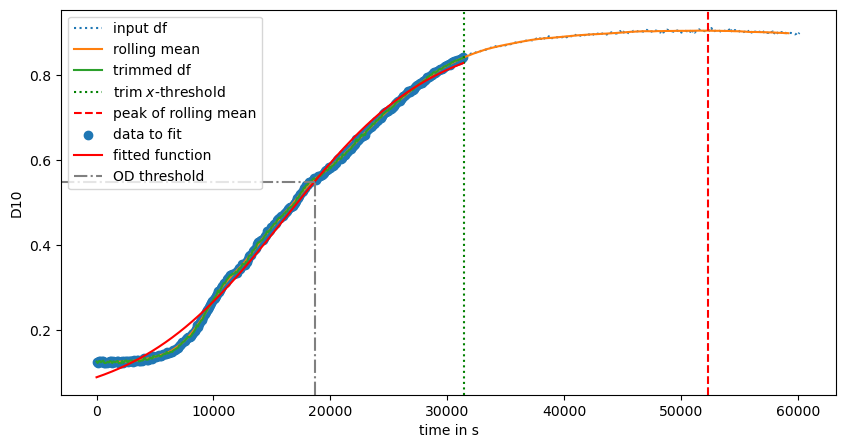

Testing trim and fit for D11
The peak is found at x= 58903.5 resulting in a trim at x= 35342


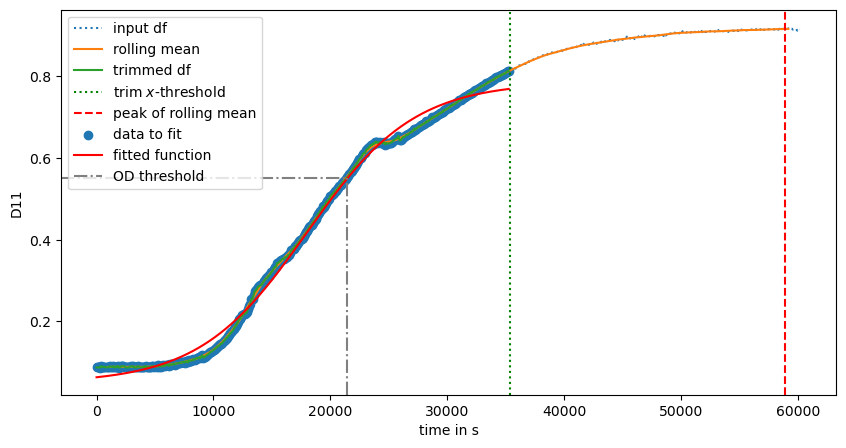

Testing trim and fit for D12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


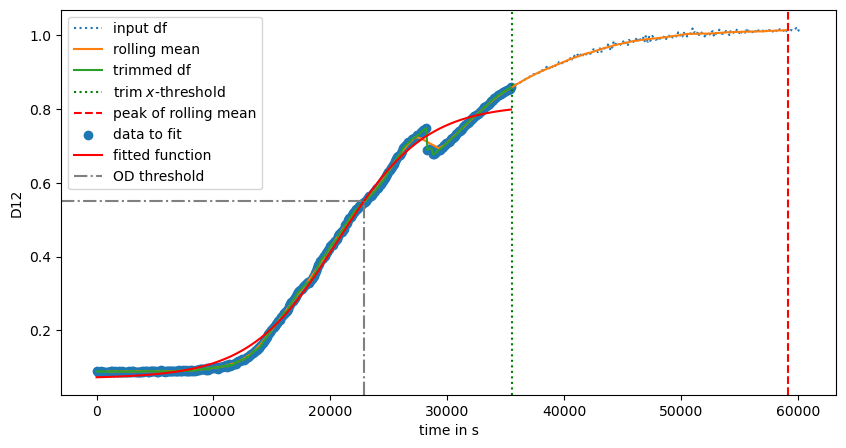

Testing trim and fit for E1
The peak is found at x= 39173.7 resulting in a trim at x= 23504


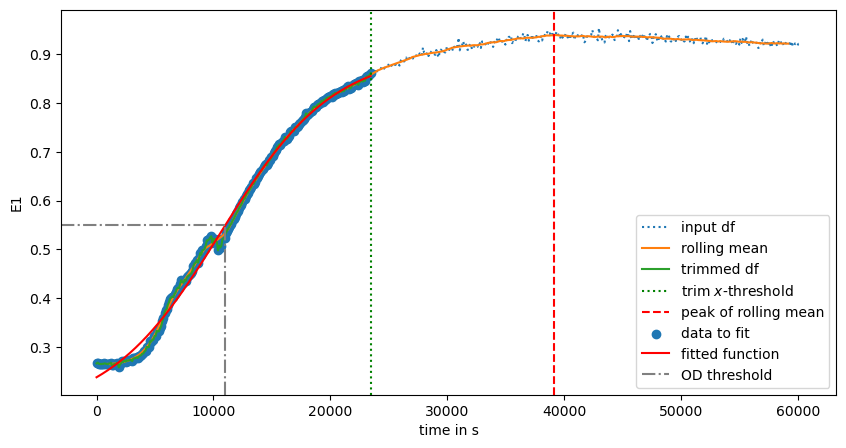

Testing trim and fit for E2
The peak is found at x= 45845.8 resulting in a trim at x= 27507


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2252252516.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, trimmed_df.index, trimmed_df, p0=[0.8, 10000, 0.0001,0.4])


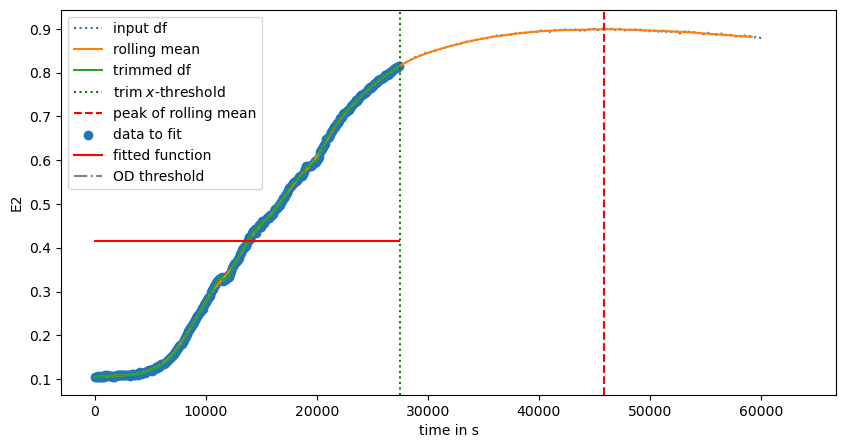

Testing trim and fit for E3
The peak is found at x= 53470.7 resulting in a trim at x= 32082


C:\Users\Philipp\AppData\Local\Temp\ipykernel_26988\2385039485.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitfunction, data_to_plot.index, data_to_plot, p0=[0.8, 10000, 0.0001,0.4])


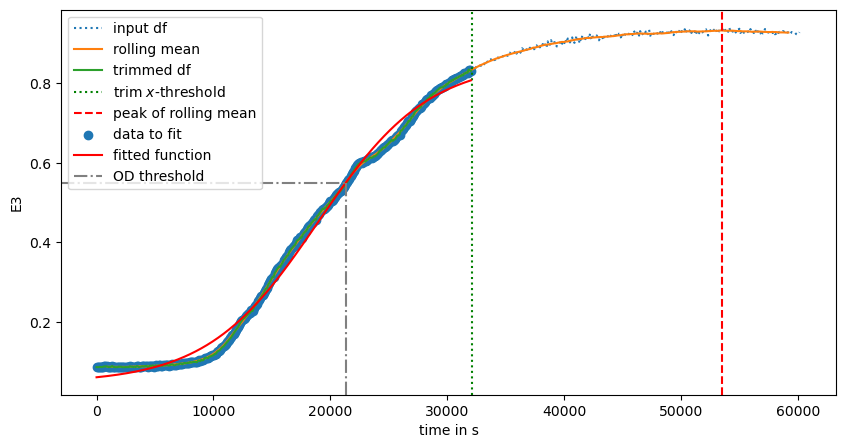

Testing trim and fit for E4
The peak is found at x= 59189.4 resulting in a trim at x= 35514


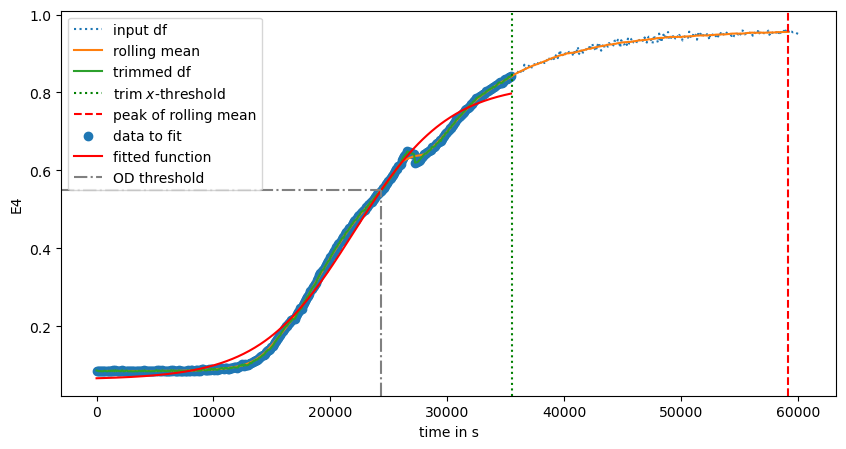

Testing trim and fit for E5
The peak is found at x= 49563.0 resulting in a trim at x= 29738


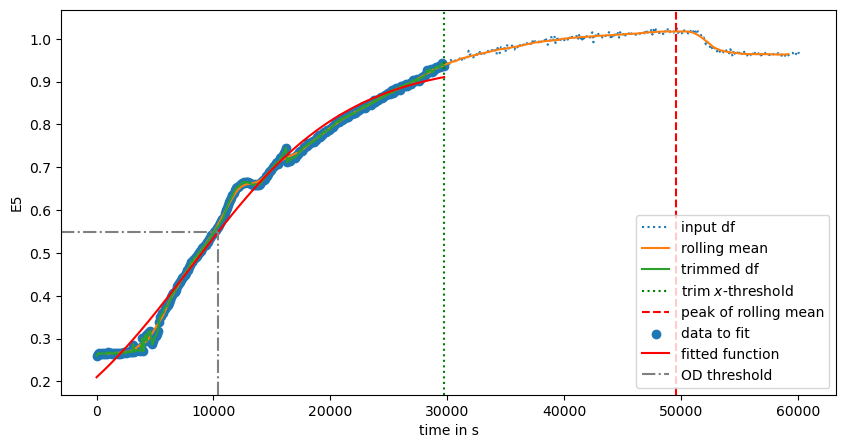

Testing trim and fit for E6
The peak is found at x= 52517.6 resulting in a trim at x= 31511


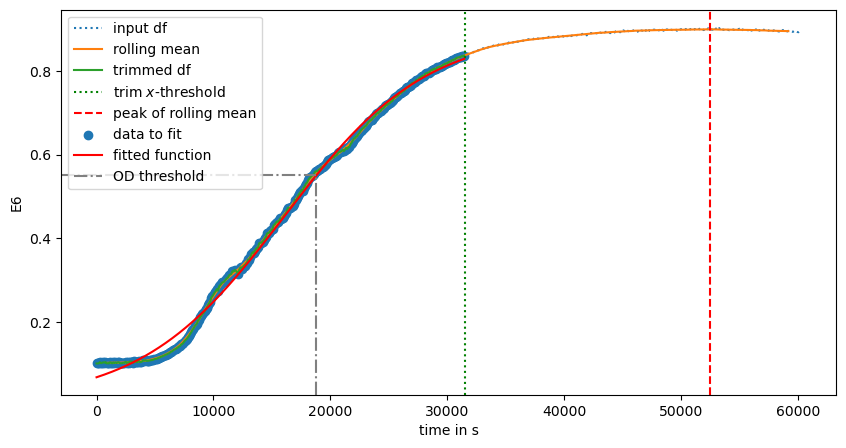

Testing trim and fit for E7
The peak is found at x= 56139.4 resulting in a trim at x= 33684


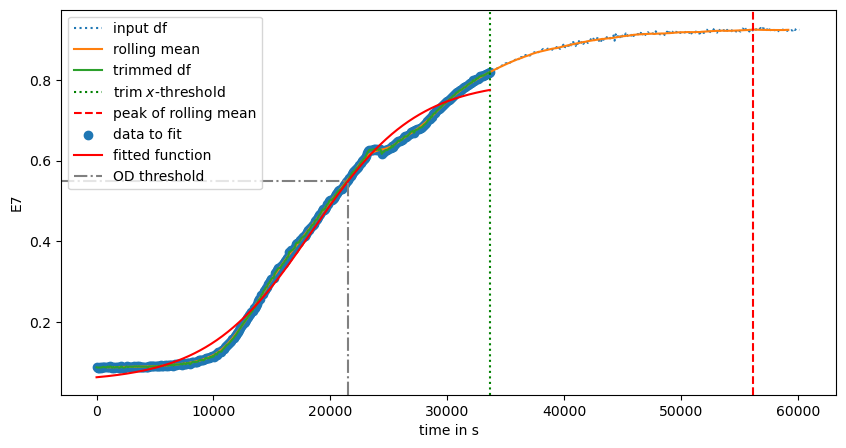

Testing trim and fit for E8
The peak is found at x= 58522.1 resulting in a trim at x= 35113


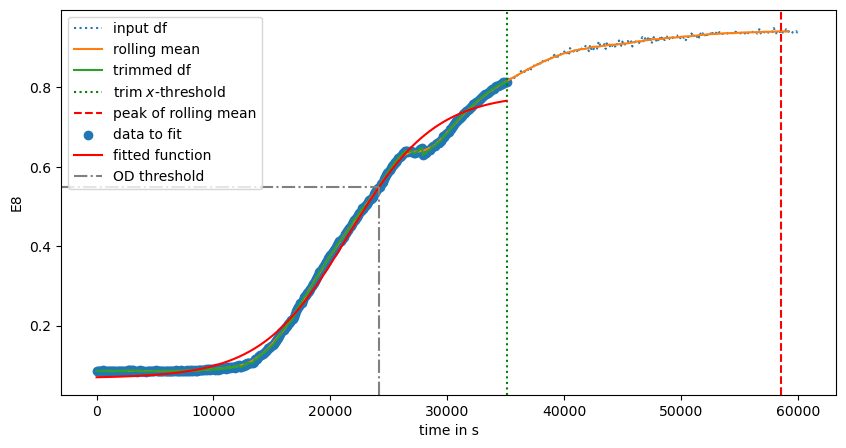

Testing trim and fit for E9
The peak is found at x= 49944.2 resulting in a trim at x= 29967


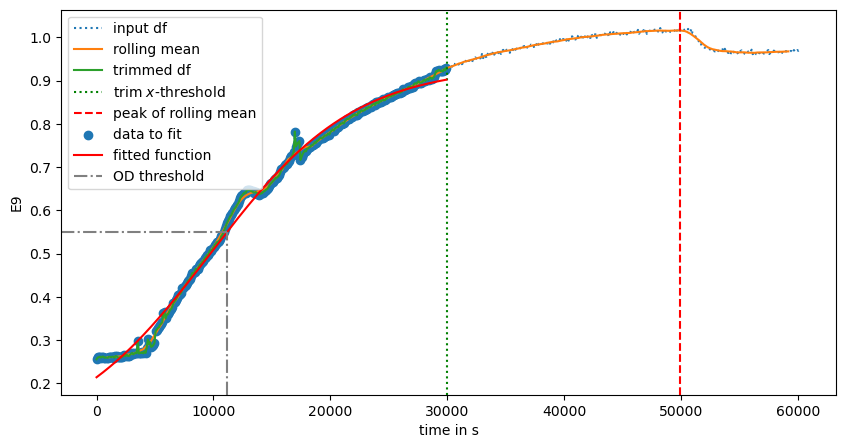

Testing trim and fit for E10
The peak is found at x= 42414.3 resulting in a trim at x= 25449


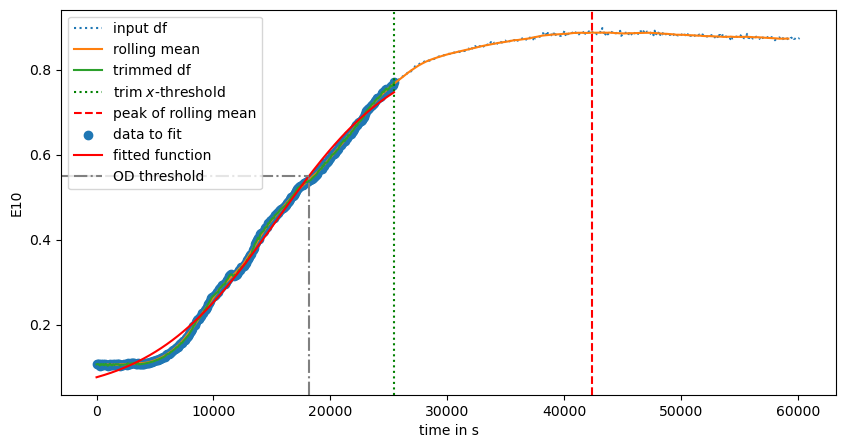

Testing trim and fit for E11
The peak is found at x= 59189.4 resulting in a trim at x= 35514


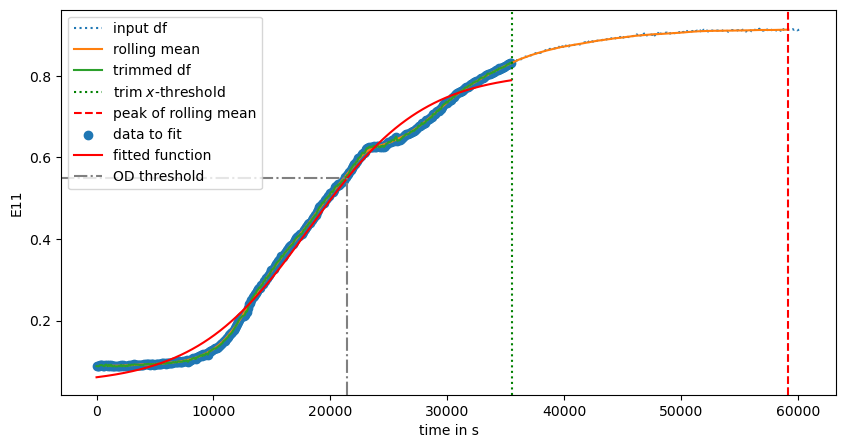

Testing trim and fit for E12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


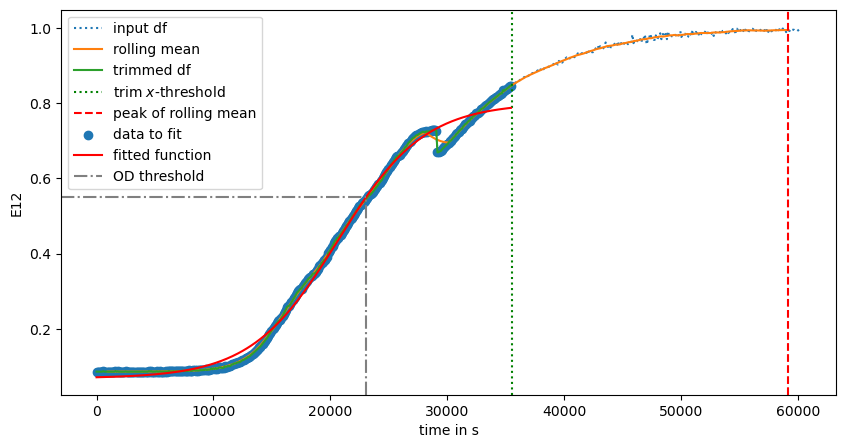

Testing trim and fit for F1
The peak is found at x= 43939.5 resulting in a trim at x= 26364


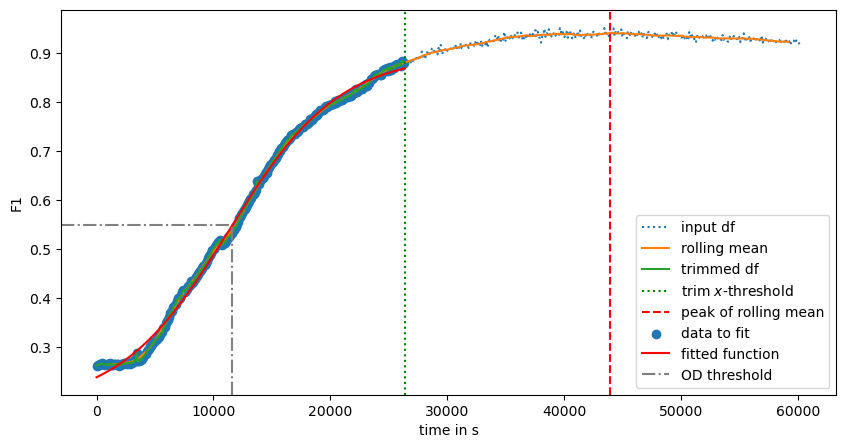

Testing trim and fit for F2
The peak is found at x= 45941.1 resulting in a trim at x= 27565


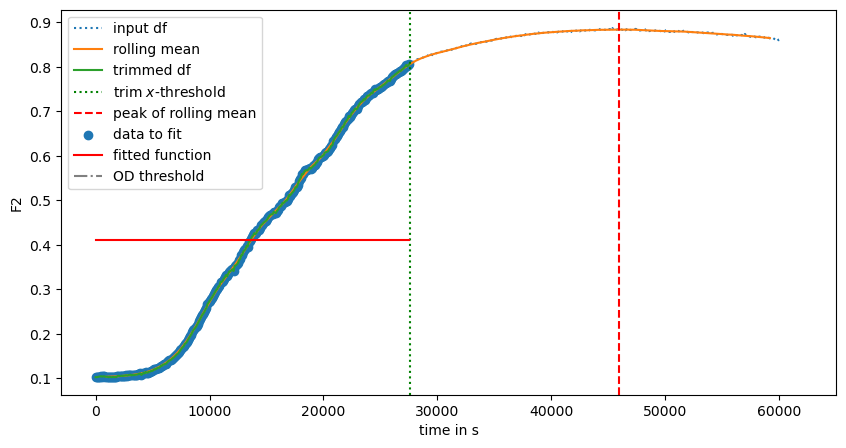

Testing trim and fit for F3
The peak is found at x= 56044.0 resulting in a trim at x= 33626


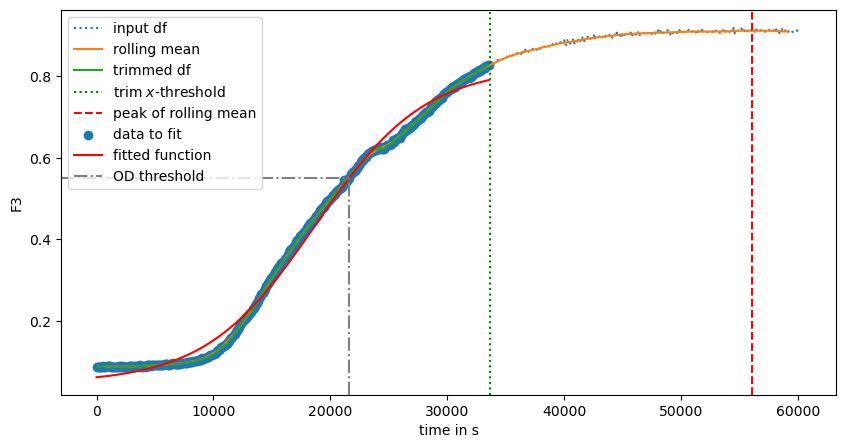

Testing trim and fit for F4
The peak is found at x= 57950.3 resulting in a trim at x= 34770


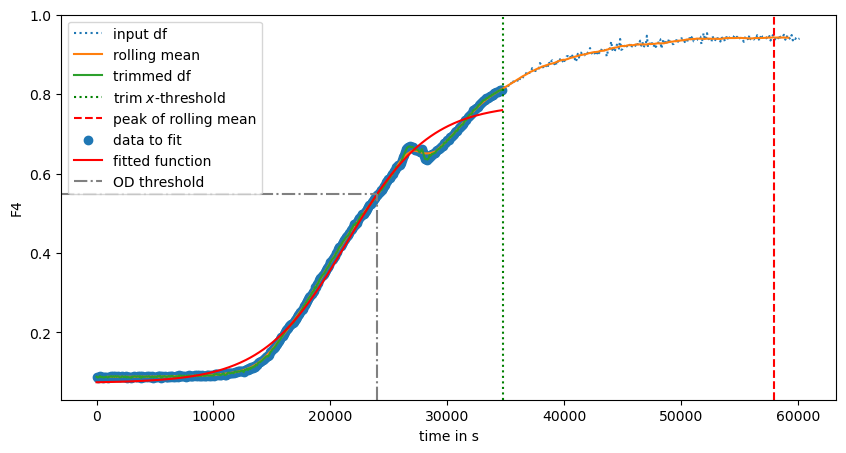

Testing trim and fit for F5
The peak is found at x= 52708.2 resulting in a trim at x= 31625


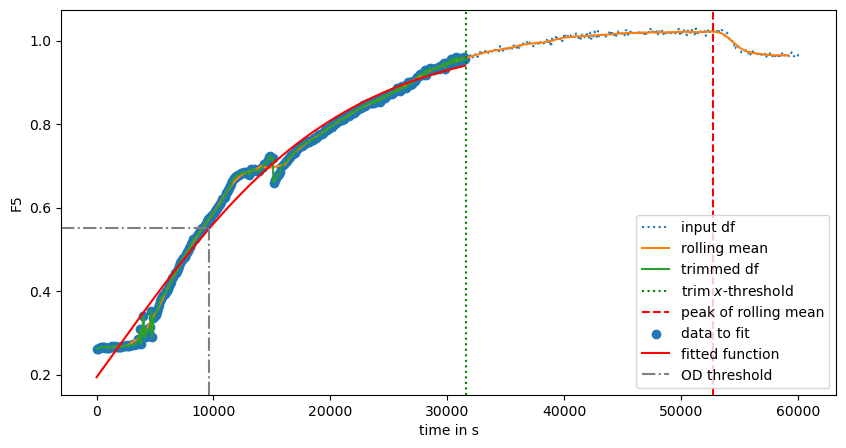

Testing trim and fit for F6
The peak is found at x= 48419.2 resulting in a trim at x= 29052


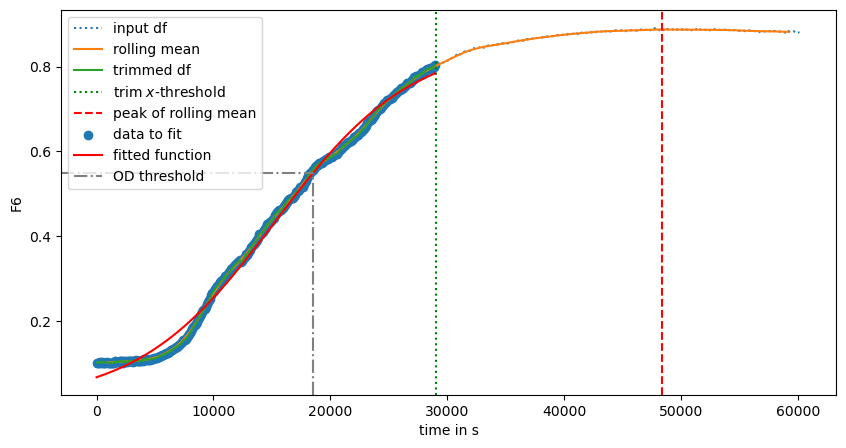

Testing trim and fit for F7
The peak is found at x= 57759.7 resulting in a trim at x= 34656


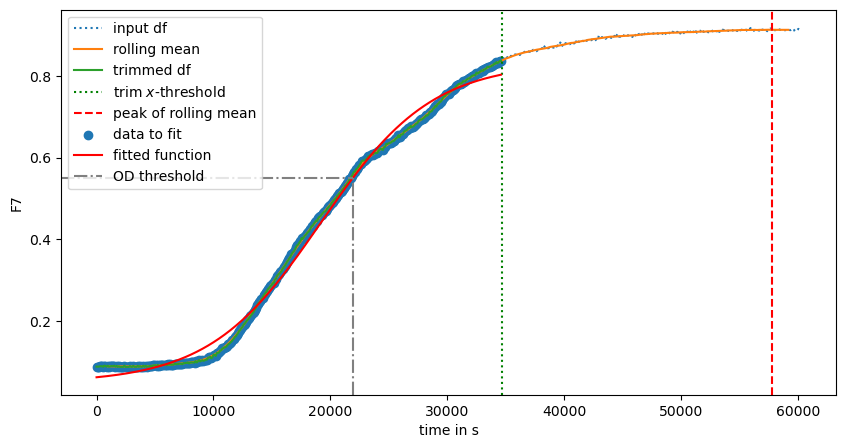

Testing trim and fit for F8
The peak is found at x= 59189.4 resulting in a trim at x= 35514


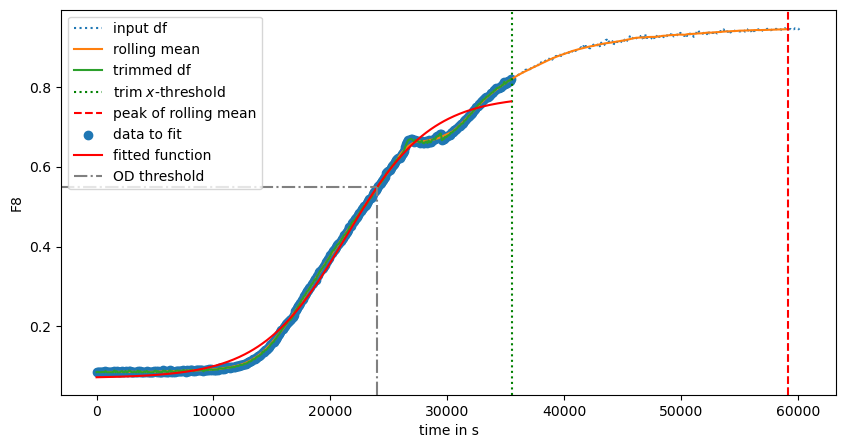

Testing trim and fit for F9
The peak is found at x= 51278.5 resulting in a trim at x= 30767


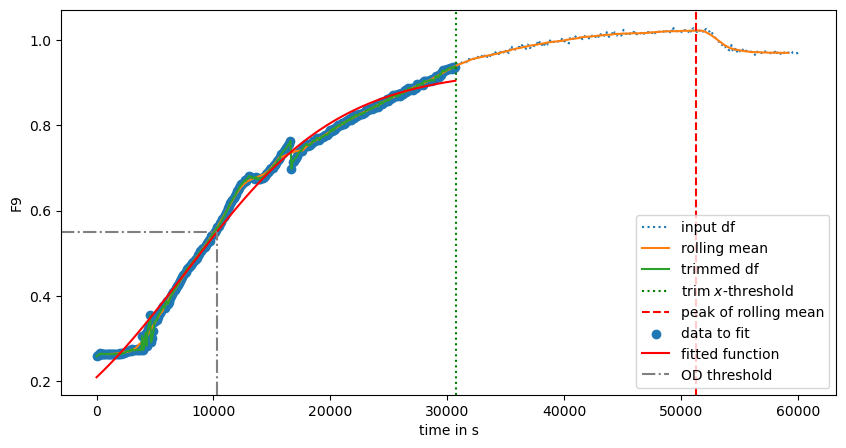

Testing trim and fit for F10
The peak is found at x= 49277.0 resulting in a trim at x= 29566


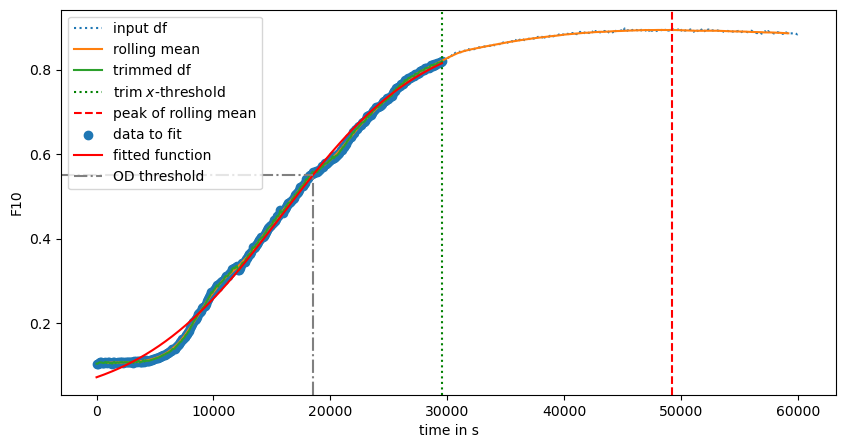

Testing trim and fit for F11
The peak is found at x= 56520.6 resulting in a trim at x= 33912


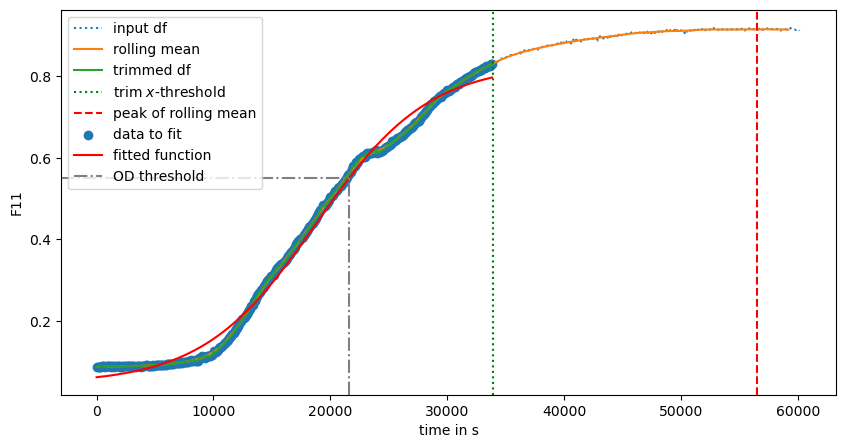

Testing trim and fit for F12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


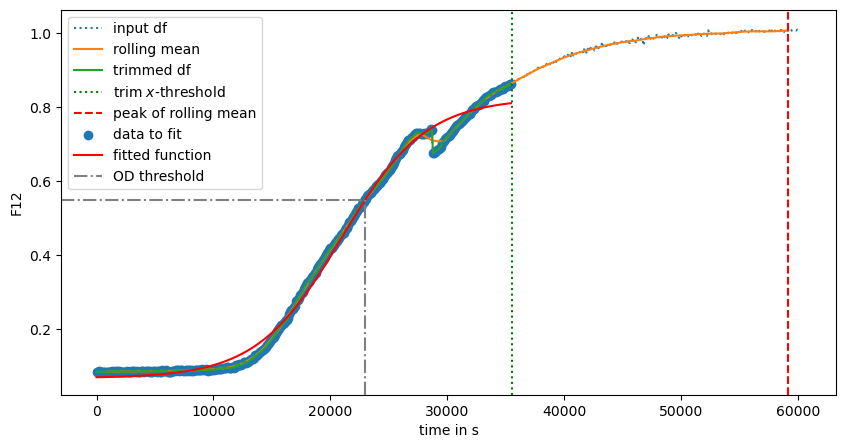

Testing trim and fit for G1
The peak is found at x= 41461.2 resulting in a trim at x= 24877


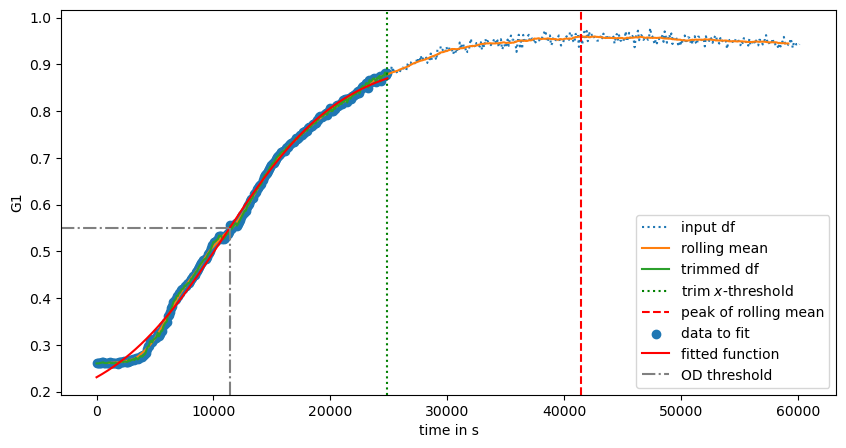

Testing trim and fit for G2
The peak is found at x= 47370.8 resulting in a trim at x= 28422


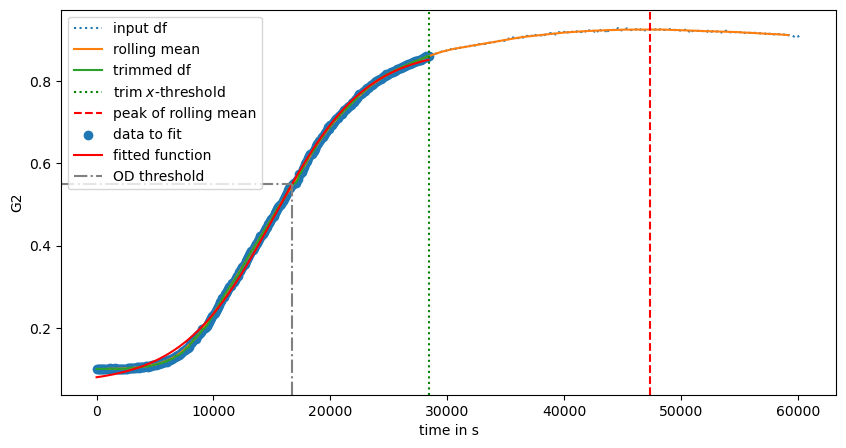

Testing trim and fit for G3
The peak is found at x= 54519.1 resulting in a trim at x= 32711


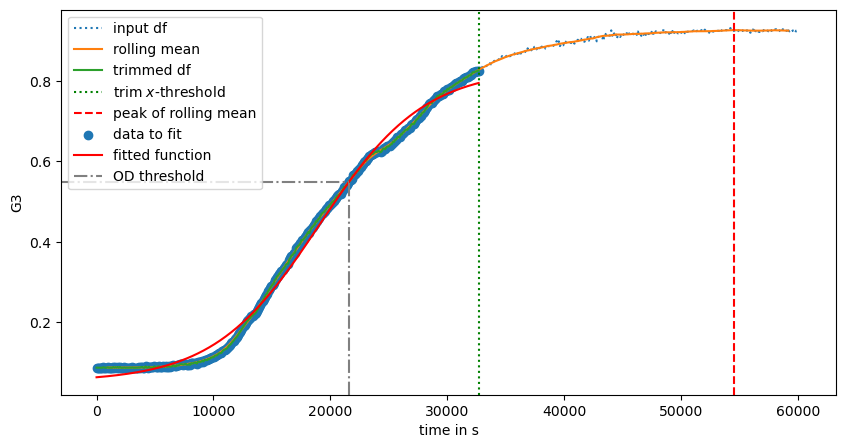

Testing trim and fit for G4
The peak is found at x= 58998.8 resulting in a trim at x= 35399


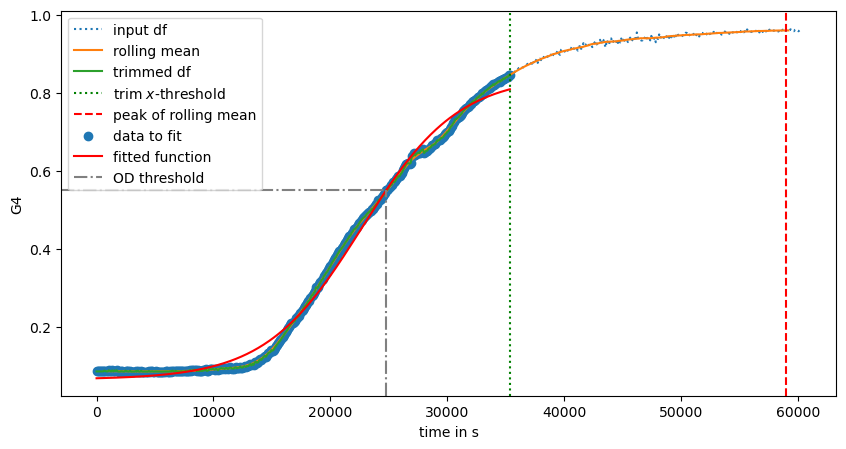

Testing trim and fit for G5
The peak is found at x= 49753.6 resulting in a trim at x= 29852


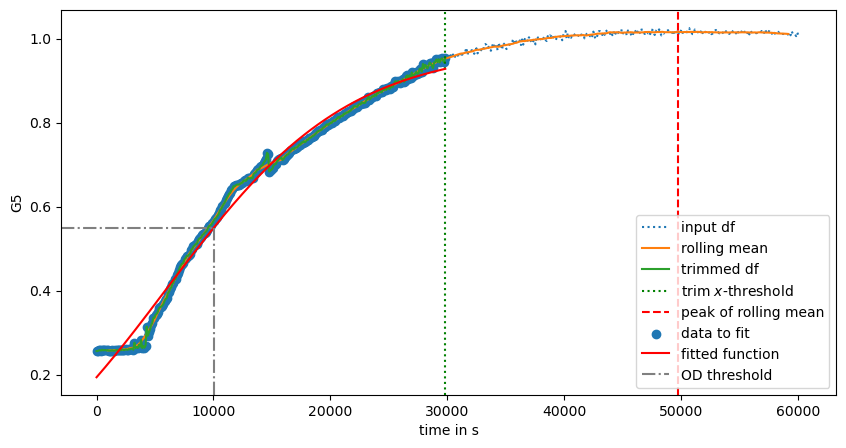

Testing trim and fit for G6
The peak is found at x= 49563.0 resulting in a trim at x= 29738


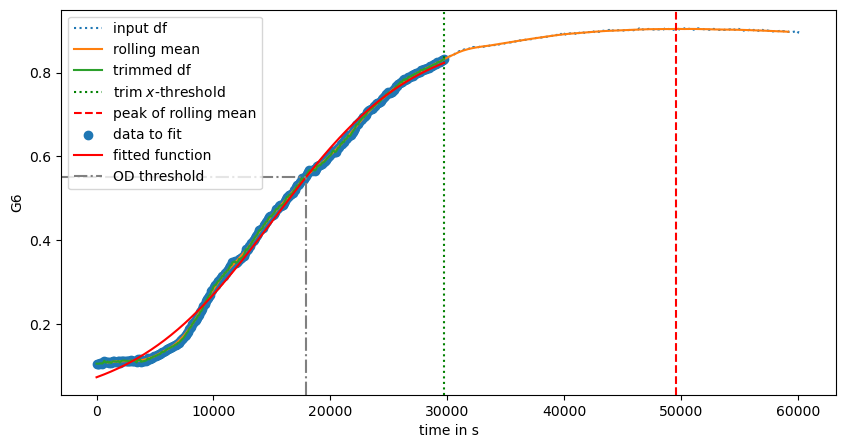

Testing trim and fit for G7
The peak is found at x= 58903.5 resulting in a trim at x= 35342


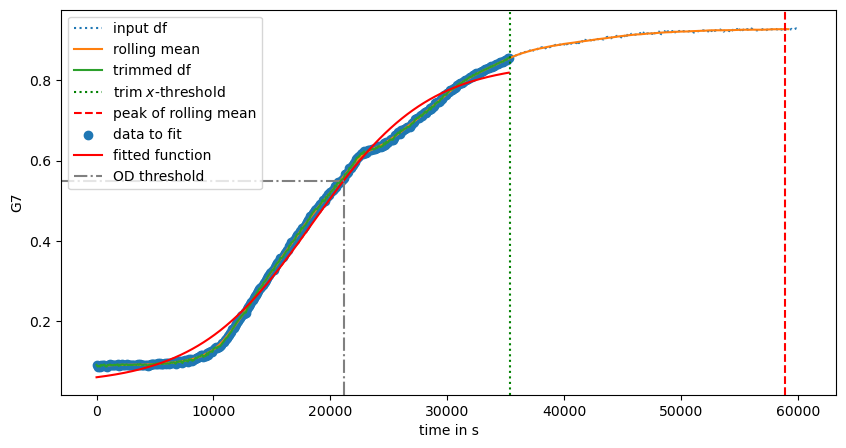

Testing trim and fit for G8
The peak is found at x= 58998.8 resulting in a trim at x= 35399


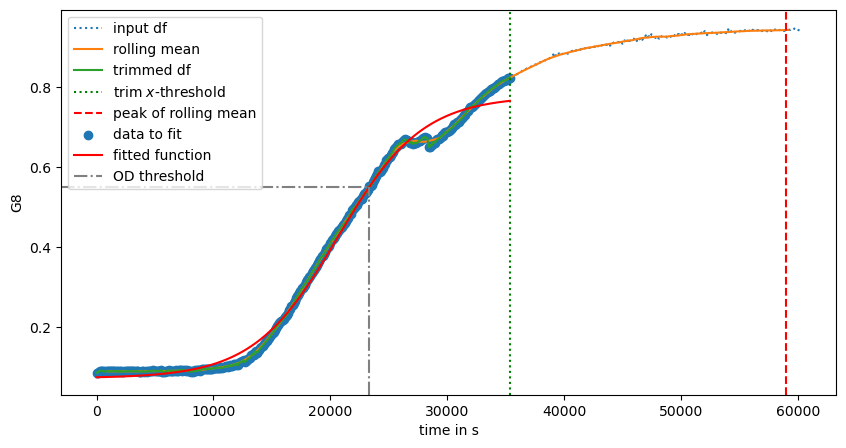

Testing trim and fit for G9
The peak is found at x= 52517.6 resulting in a trim at x= 31511


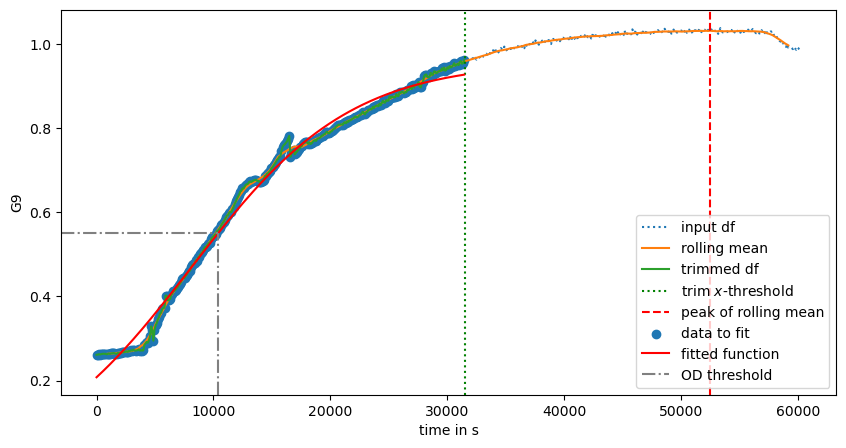

Testing trim and fit for G10
The peak is found at x= 51183.2 resulting in a trim at x= 30710


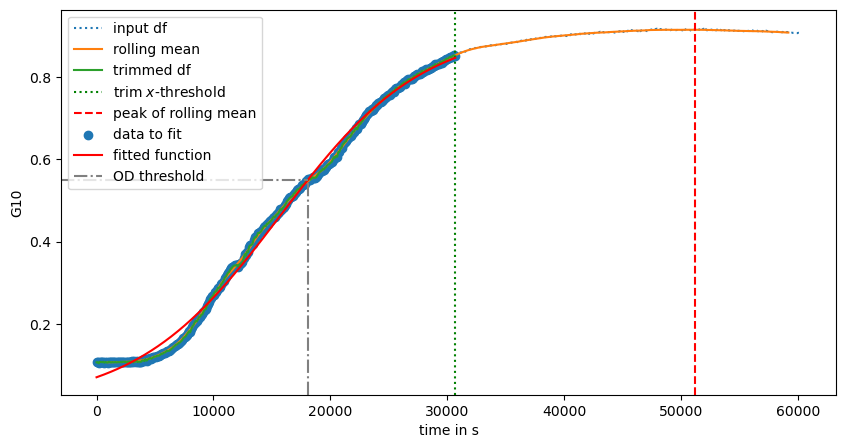

Testing trim and fit for G11
The peak is found at x= 52041.0 resulting in a trim at x= 31225


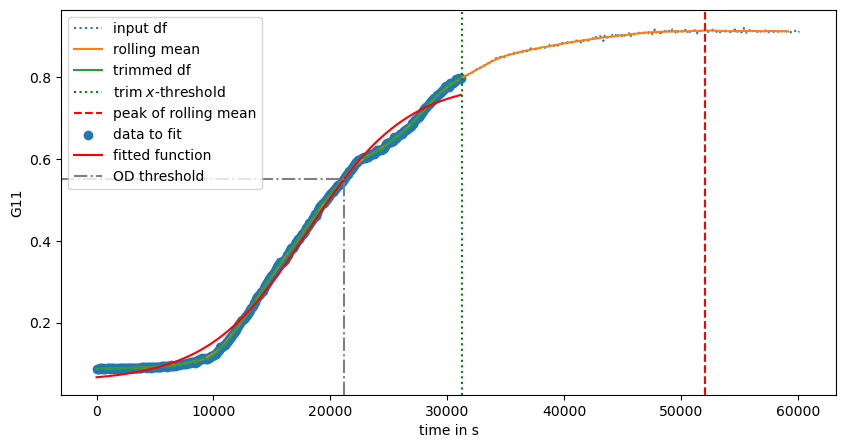

Testing trim and fit for G12
The peak is found at x= 59189.4 resulting in a trim at x= 35514


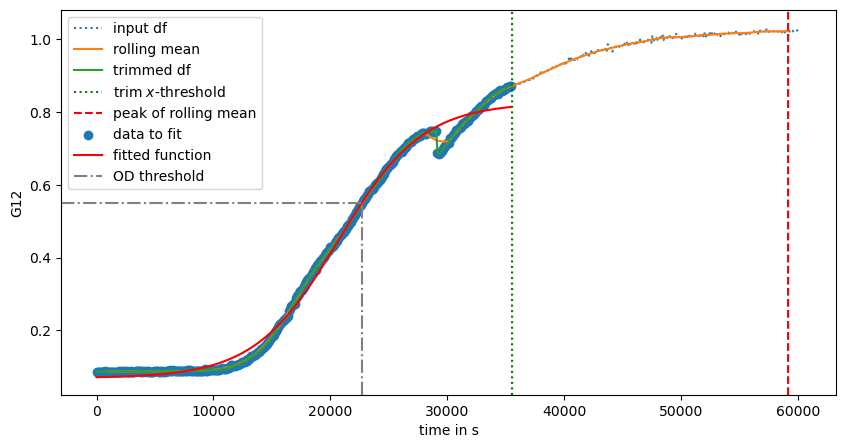

Testing trim and fit for H1
The peak is found at x= 45941.1 resulting in a trim at x= 27565


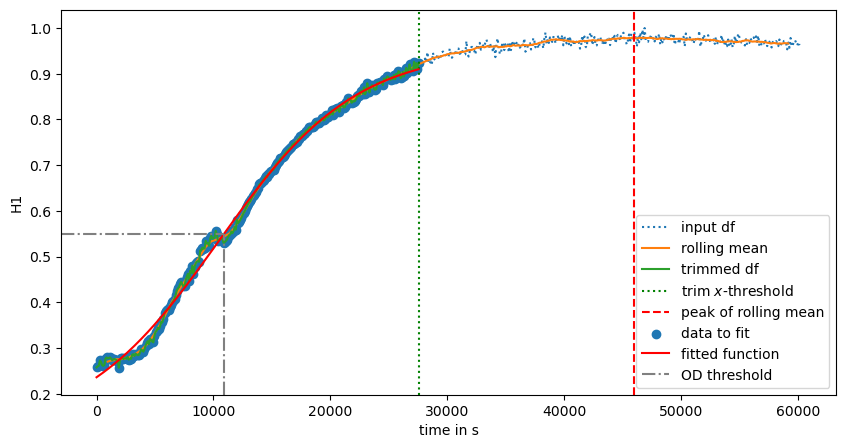

Testing trim and fit for H2
The peak is found at x= 46703.6 resulting in a trim at x= 28022


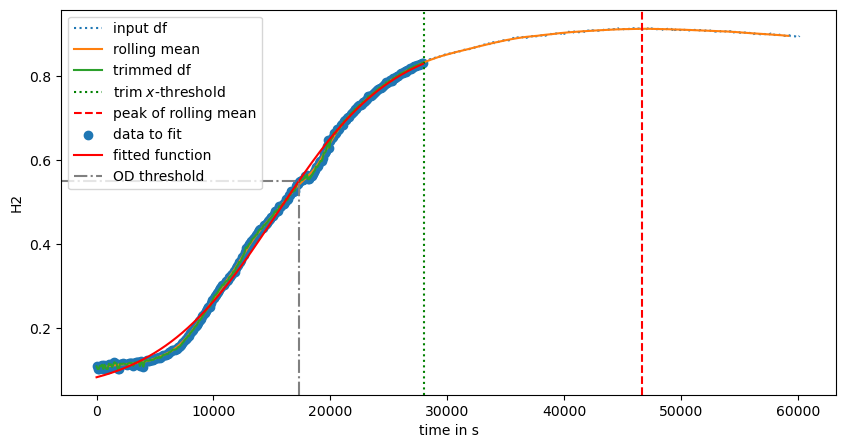

Testing trim and fit for H3
The peak is found at x= 55376.9 resulting in a trim at x= 33226


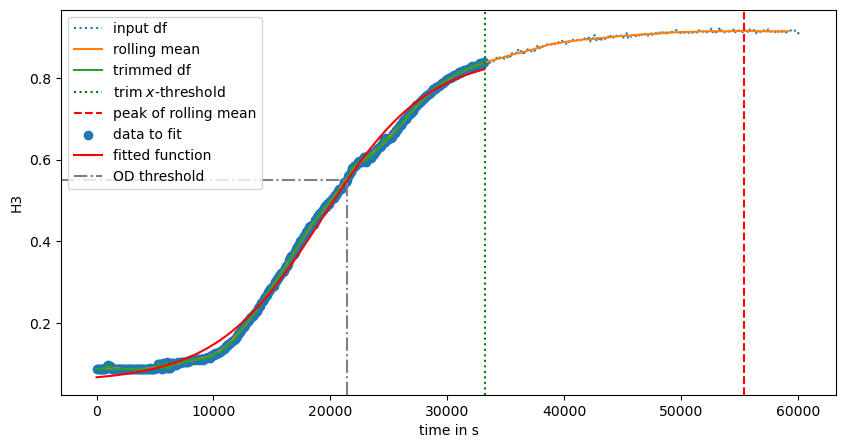

Testing trim and fit for H4
The peak is found at x= 59189.4 resulting in a trim at x= 35514


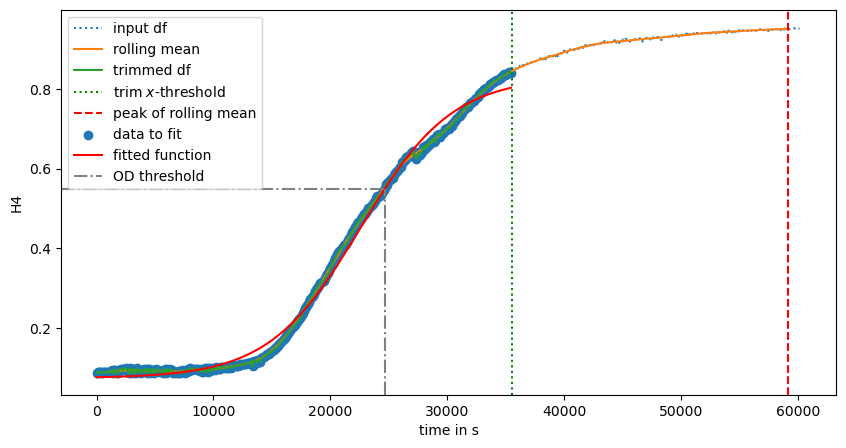

Testing trim and fit for H5
The peak is found at x= 48038.0 resulting in a trim at x= 28823


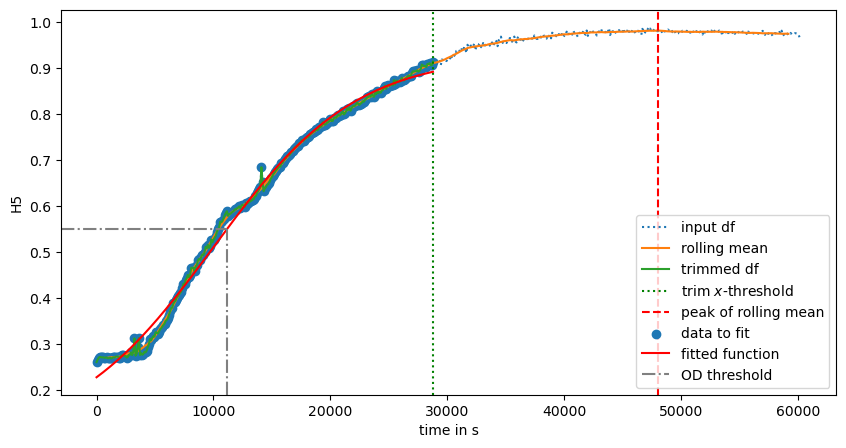

Testing trim and fit for H6
The peak is found at x= 46798.9 resulting in a trim at x= 28079


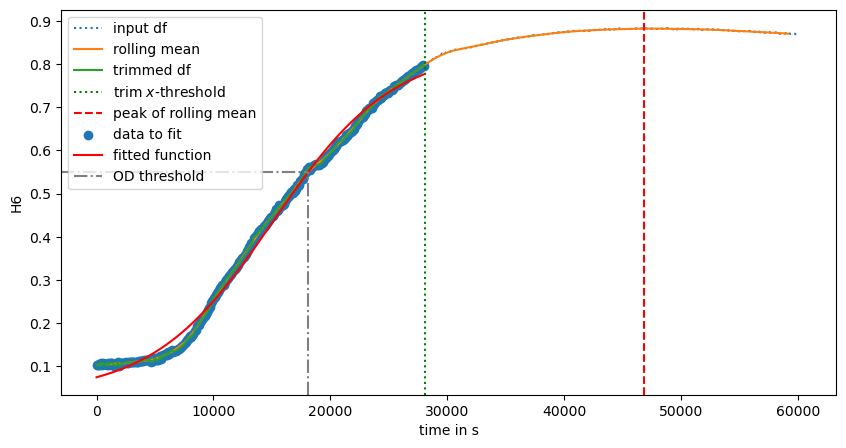

Testing trim and fit for H7
The peak is found at x= 56520.6 resulting in a trim at x= 33912


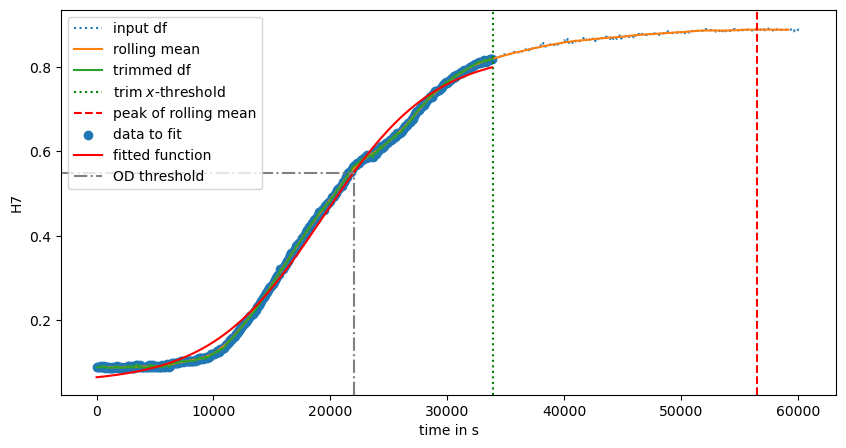

Testing trim and fit for H8
The peak is found at x= 59094.1 resulting in a trim at x= 35456


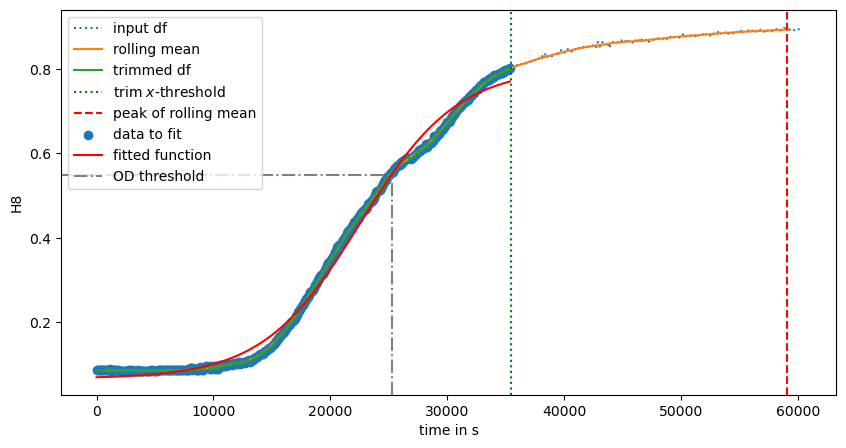

Testing trim and fit for H9
The peak is found at x= 47466.1 resulting in a trim at x= 28480


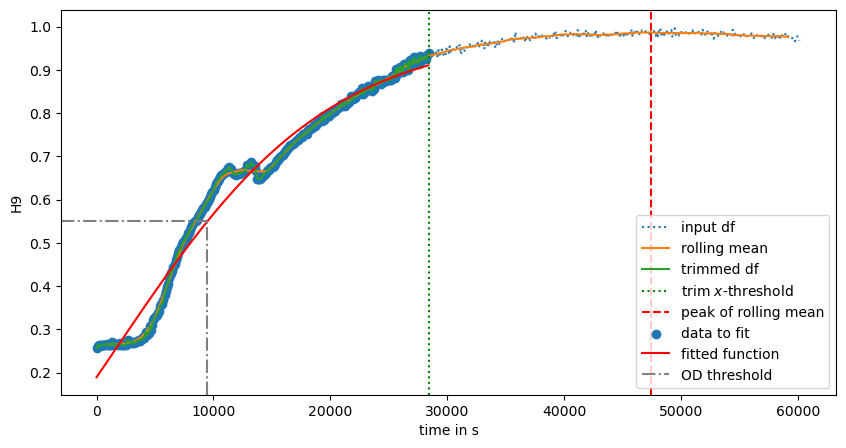

Testing trim and fit for H10
The peak is found at x= 45845.8 resulting in a trim at x= 27507


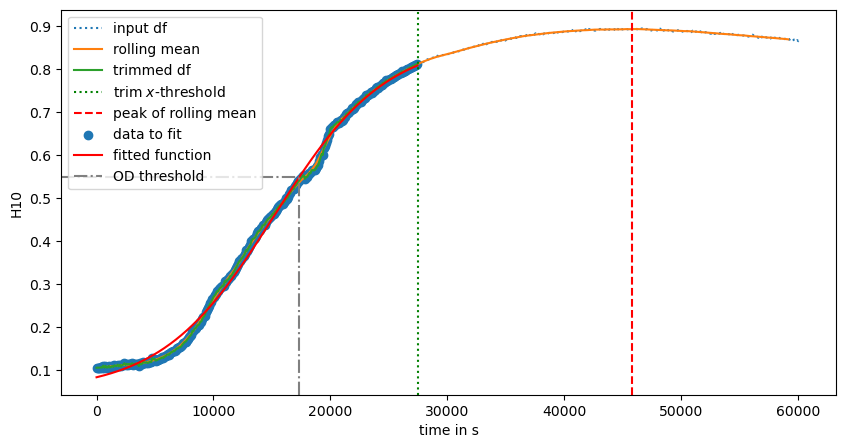

Testing trim and fit for H11
The peak is found at x= 50802.0 resulting in a trim at x= 30481


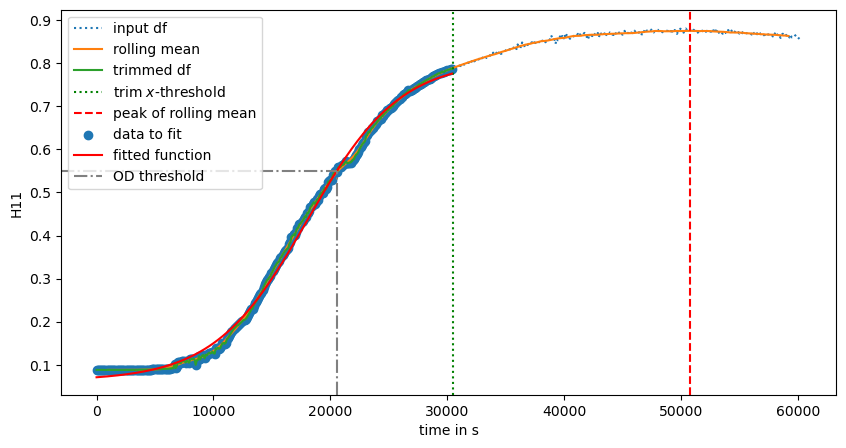

Testing trim and fit for H12
The peak is found at x= 49086.4 resulting in a trim at x= 29452


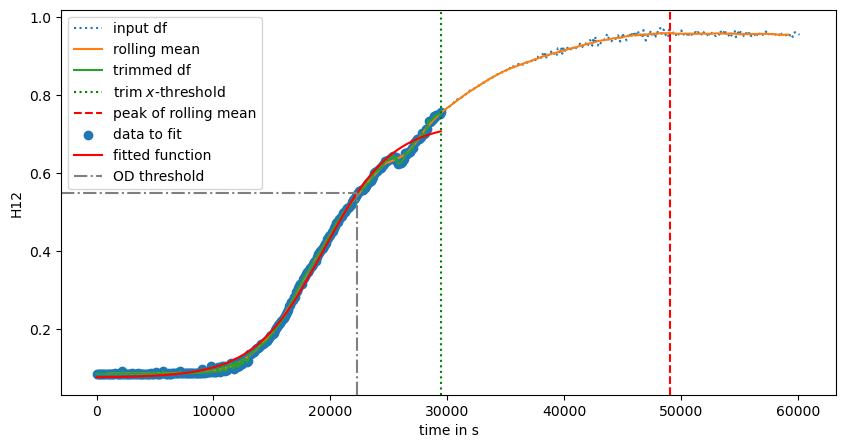

Failed wells: []


In [143]:
# set verbosity of output (whether to show plots for each well)
temp_debug = True

# Initialize an empty DataFrame to store the parameters 
df_parameters = pd.DataFrame(columns=['L', 'x0', 'k', 'offset'], index=df_OD_reads.columns, dtype=np.float64)

# create list to store failed wells to
failed_wells = []


# Iterate over all samples 
for well in df_OD_reads.columns: 
#for well in ["A2", "A3", "A4", "A5"]:
    print("Testing trim and fit for", well)
    try:
        data_to_plot = trim_curve(df_OD_reads[well], debug=temp_debug, trim_ratio=0.4)
        # Apply curve_fit to each sample
        popt, pcov = curve_fit(fitfunction, data_to_plot.index, data_to_plot, p0=[0.8, 10000, 0.0001,0.4])
        # Store the parameters in df_parameters
        df_parameters.loc[well] = popt
    except:
        failed_wells.append(well)
        df_parameters.loc[well] = (np.nan, np.nan, np.nan, np.nan)
        print("\x1b[31m\x1b[0m")
        for _ in range(10): print("\x1b[31mFAIL!!!!!!!!!!!!!!\x1b[0m")
        print("Failed trimming and fitting", well)
        for _ in range(10): print("\x1b[31mFAIL!!!!!!!!!!!!!!!!\x1b[0m")
#sns.lineplot(data = data_to_plot)
print("Failed wells:", failed_wells)

# Add column with real carrying capacity L+offset
df_parameters["L_plus_offset"] = df_parameters["L"] + df_parameters["offset"]

# Add column with where fit function = OD threshold is hit
df_parameters["x_threshold"] = inverse_fitfunction(OD_threshold, df_parameters["L"], df_parameters["x0"], df_parameters["k"], df_parameters["offset"])

In [144]:
df_parameters.head()

L            x0         k    offset  L_plus_offset   x_threshold
A1  1.540829   -228.471420  0.000101 -0.576910       0.963919   9671.255409
A2  0.817889  14683.860746  0.000193  0.025369       0.843258  17699.619311
A3  0.775797  18490.207869  0.000218  0.047141       0.822938  21296.564941
A4  0.644865  20306.637765  0.000341  0.077157       0.722022  23275.107666
A5  0.945075   6625.087523  0.000167 -0.033878       0.911196   9504.701184

In [145]:
# deactivated
if False:
    x_values = np.linspace(0, 80000, 80000)

    popt, pcov = curve_fit(fitfunction, df_OD_reads.index, df_OD_reads[well], p0=[0.8, 16000, 0.0001,1])
    plt.scatter(df_OD_reads.index,df_OD_reads[well],label='data')
    plt.plot(x_values, fitfunction(x_values, *popt), 'r-',label='Fitted function')
    plt.yscale("log")
    plt.legend()

# Testing other fits

In [146]:
#deactivated
if False:
    popt, pcov = curve_fit(exponentialfunction, data_to_plot.loc[(data_to_plot.index > 5000) & (data_to_plot.index < 17500)].index.values, data_to_plot.loc[(data_to_plot.index > 5000) & (data_to_plot.index < 17500)].values, p0=[4.69747835e-02, 1.39494215e-04, 1.58315988e+03, 0])
    plt.scatter(data_to_plot.loc[(data_to_plot.index > 5000) & (data_to_plot.index < 17500)].index.values, data_to_plot.loc[(data_to_plot.index > 5000) & (data_to_plot.index < 17500)].values,label='data')
    plt.plot(np.linspace(5000,17500), exponentialfunction(np.linspace(500,17500), 0.05, 0.00015, 0, 0), 'r-',label='Fitted function')
    plt.plot(np.linspace(5000,17500), exponentialfunction(np.linspace(500,17500), *popt), 'g-',label='Fitted function')

In [147]:
#deactivated

# Polynomial fit
if False:
    # Assuming x and y are your data
    x = np.array(trim_curve(df_OD_reads[well]).index)
    y = np.array(trim_curve(df_OD_reads[well]))

    # Fit with polyfit
    degree = 10
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)

    # Generate a number of x values
    x_fit = np.linspace(min(x), max(x), 500)
    y_fit = polynomial(x_fit)

    # Plot the original data and the fit
    plt.figure(figsize=(10,6))
    plt.plot(x, y, 'o', label='Original data')
    plt.plot(x_fit, y_fit, '-', label='Fit: %s' % polynomial)
    plt.legend()
    plt.show()

## Calculating intervals

In [148]:
df_successful_parameters = df_parameters[~df_parameters.isnull().any(axis=1)]

In [149]:
df_successful_parameters

L            x0         k    offset  L_plus_offset   x_threshold
A1   1.540829   -228.471420  0.000101 -0.576910       0.963919   9671.255409
A2   0.817889  14683.860746  0.000193  0.025369       0.843258  17699.619311
A3   0.775797  18490.207869  0.000218  0.047141       0.822938  21296.564941
A4   0.644865  20306.637765  0.000341  0.077157       0.722022  23275.107666
A5   0.945075   6625.087523  0.000167 -0.033878       0.911196   9504.701184
..        ...           ...       ...       ...            ...           ...
H8   0.736868  22547.710594  0.000240  0.066010       0.802878  25247.521673
H9   1.462367   1620.930734  0.000109 -0.477224       0.985143   9486.161422
H10  0.816761  15191.563711  0.000209  0.050676       0.867437  17362.386339
H11  0.743970  18021.135130  0.000252  0.063168       0.807138  20550.173157
H12 -0.653444  19413.466787 -0.000337  0.729174       0.075730  22298.126426

[96 rows x 6 columns]

In [150]:
# store, which wells were successfully fitted to pair them later

successful_dilutions = {
    1: [],
    10: [],
    100: [],
    1000: []
}

for dilution in [1, 10, 100, 1000]:
    for well in dilutions[dilution]:
        if well in df_successful_parameters.index:
            successful_dilutions[dilution].append(well)
        else:
            successful_dilutions[dilution].append(None)

In [151]:
successful_dilutions

{1: ['A1',
  'A5',
  'A9',
  'B1',
  'B5',
  'B9',
  'C1',
  'C5',
  'C9',
  'D1',
  'D5',
  'D9',
  'E1',
  'E5',
  'E9',
  'F1',
  'F5',
  'F9',
  'G1',
  'G5',
  'G9',
  'H1',
  'H5',
  'H9'],
 10: ['A2',
  'A6',
  'A10',
  'B2',
  'B6',
  'B10',
  'C2',
  'C6',
  'C10',
  'D2',
  'D6',
  'D10',
  'E2',
  'E6',
  'E10',
  'F2',
  'F6',
  'F10',
  'G2',
  'G6',
  'G10',
  'H2',
  'H6',
  'H10'],
 100: ['A3',
  'A7',
  'A11',
  'B3',
  'B7',
  'B11',
  'C3',
  'C7',
  'C11',
  'D3',
  'D7',
  'D11',
  'E3',
  'E7',
  'E11',
  'F3',
  'F7',
  'F11',
  'G3',
  'G7',
  'G11',
  'H3',
  'H7',
  'H11'],
 1000: ['A4',
  'A8',
  'A12',
  'B4',
  'B8',
  'B12',
  'C4',
  'C8',
  'C12',
  'D4',
  'D8',
  'D12',
  'E4',
  'E8',
  'E12',
  'F4',
  'F8',
  'F12',
  'G4',
  'G8',
  'G12',
  'H4',
  'H8',
  'H12']}

## Alternative approach: Minimize mean squared deviation (MSD/MSE)

We try possible offsets and pick the one which has lowest $ \sum_x(f_1(x)-f_2(x + \tau))^2$

### or maximize cross correlation
$\sum_x(f_1(x)*f_2(x+\tau))$

In [160]:
def subtract_timeseries(ts1, ts2):
    """
    Subtract two time series element-wise, not regarding the index.

    Parameters:
    ts1 (pd.Series): The first time series.
    ts2 (pd.Series): The second time series.

    Returns:
    pd.Series: The result of the subtraction.
    """
    # Ensure that both time series are pandas Series and convert them o numpy arrays
    array1 = pd.Series(ts1).to_numpy()
    array2 = pd.Series(ts2).to_numpy()

    # Create a new array with the length of the longer array
    if len(array1) > len(array2):
        array2 = np.concatenate([array2, [np.nan] * (len(array1) - len(array2))])
    else:
        array1 = np.concatenate([array1, [np.nan] * (len(array2) - len(array1))])

    # Subtract the arrays element-wise
    result = pd.Series(array1 - array2)

    return result


In [161]:
def find_offset(timeseries1, timeseries2, method = "MSD"):
    """
    Calculate the offset between two time series.

    Parameters:
    timeseries1 (pd.Series): The first (smaller/trimmed) time series.
    timeseries2 (pd.Series): The second time series, which must be at least twice as long as timeseries1.
    method (str): The method to use for finding the offset. Options are "MSD" (mean squared deviation) and "correlation" (cross-correlation). Default is "MSD".

    Returns:
    int: The offset with the smallest sum of squared deviations.
    """
    # Check for vlaid input
    if 2*len(timeseries1) >= len(timeseries2):
        raise ValueError("timeseries1 must be at least half the size of timeseries2.")
    
    # Initialize variables
    min_value = np.inf  # Initialize minimum difference
    best_offset = 0  # Initialize best offset
    
    # Iterate over possible offsets
    for offset in range(len(timeseries2) - len(timeseries1) + 1):
        if method == "MSD":
            # Calculate squared difference between the two timeseries
            value = np.sum(np.square((subtract_timeseries(timeseries1,timeseries2.iloc[offset:len(timeseries1)+offset]))))

        elif method == "correlation":
            raise NotImplementedError("Cross-correlation is not implemented yet.")
            # Calculate the cross-correlation between the two timeseries
            #value = -np.sum(np.correlate(timeseries1, timeseries2, mode='full')) # minus sign to get the maximum
            #print("offset", offset, "value", value)
            
        # Update minimum difference and best offset if a smaller difference is found
        if value < min_value:
                min_value = value
                best_offset = offset
    return best_offset

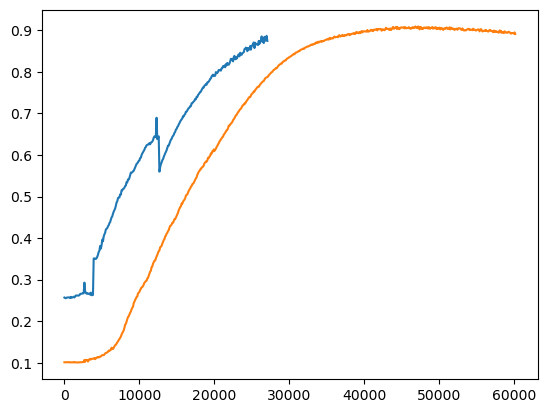

In [152]:
plt.plot(trim_curve(df_OD_reads["A1"], trim_ratio=0.5))
plt.plot(df_OD_reads["A2"])

In [153]:
find_offset(trim_curve(df_OD_reads["A1"], trim_ratio=0.5), df_OD_reads["A2"])

84

In [154]:
df_OD_reads["A2"].index[84]

8006.2

# Compute the intervals between the time series

In [155]:
# compute x-intervals between corresponding wells

method = "MSD" # or "fit"

if method == "MSD":
    successful_dilutions = dilutions

intervals = []

for dilution in [1, 10, 100]:
    for i in range(len(successful_dilutions[dilution])):
        # if well itself and 10-fold more diluted one was successful
        if not successful_dilutions[dilution][i] == None and not successful_dilutions[dilution*10][i] == None:
            if method == "fit":
                # compute time difference
                delay = df_successful_parameters.loc[successful_dilutions[dilution*10][i]]["x_threshold"] - df_successful_parameters.loc[successful_dilutions[dilution][i]]["x_threshold"]
            elif method == "MSD":
                # compute time difference
                offset = find_offset(trim_curve(df_OD_reads[successful_dilutions[dilution][i]], trim_ratio=0.5, override_halfheight_check=True), df_OD_reads[successful_dilutions[dilution*10][i]])
                delay = df_OD_reads[successful_dilutions[dilution*10][i]].index[offset]
                if delay > 5000:
                    print(offset, delay, "#######################")
            intervals.append(delay)
            print(successful_dilutions[dilution*10][i], successful_dilutions[dilution][i], intervals[-1])

84 8006.2 #######################
A2 A1 8006.2
90 8578.0 #######################
A6 A5 8578.0
72 6862.5 #######################
A10 A9 6862.5
81 7720.2 #######################
B2 B1 7720.2
76 7243.7 #######################
B6 B5 7243.7
87 8292.1 #######################
B10 B9 8292.1
80 7624.9 #######################
C2 C1 7624.9
85 8101.5 #######################
C6 C5 8101.5
84 8006.2 #######################
C10 C9 8006.2
77 7339.0 #######################
D2 D1 7339.0
88 8387.4 #######################
D6 D5 8387.4
75 7148.4 #######################
D10 D9 7148.4
76 7243.7 #######################
E2 E1 7243.7
89 8482.7 #######################
E6 E5 8482.7
78 7434.3 #######################
E10 E9 7434.3
73 6957.8 #######################
F2 F1 6957.8
93 8864.0 #######################
F6 F5 8864.0
87 8292.1 #######################
F10 F9 8292.1
65 6195.3 #######################
G2 G1 6195.3
83 7910.9 #######################
G6 G5 7910.9
82 7815.6 #######################
G10 G9 7815.6
73 695

In [167]:
if True:
    intervals = np.array(intervals)
    intervals = intervals[np.where(intervals < 5000)]

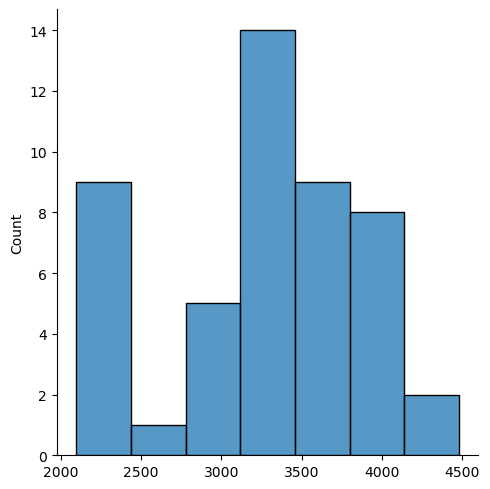

In [168]:
sns.displot(intervals)

In [169]:
# mean interval
mean_generationtime = np.mean(intervals) / (np.log2(10))

In [170]:
# in minutes
mean_generationtime / 60

16.33806853688962

In [171]:
# more comprehensive statistical properties (in minutes)
pd.Series(intervals/(np.log2(10)*60)).describe()

count    48.000000
mean     16.338069
std       2.990927
min      10.519995
25%      14.823720
50%      16.736766
75%      18.171174
max      22.474899
dtype: float64

In [172]:
#well1 = "C3"
#well2 = "C4"

#offset = find_offset(trim_curve(df_OD_reads[well1], trim_ratio=0.5), df_OD_reads[well2], method="MSD")
#print("The offset is:", offset)
#plt.plot(trim_curve(df_OD_reads[well1]), label=well1, linestyle = "dotted")
#plt.plot(df_OD_reads[well1].iloc[offset:].index, df_OD_reads[well1].iloc[:-offset], label=well1+' shifted', linestyle = "dashed")
#plt.plot(trim_curve(df_OD_reads[well2]), label=well2, linestyle = "dotted")
#plt.legend()
#plt.show()

In [173]:
#from scipy.signal import correlate, correlation_lags

#rng = np.random.default_rng()
#x = np.gradient(timeseries1)
#y = np.gradient(timeseries2)
#correlation = correlate(x, y, mode="full")
#lags = correlation_lags(x.size, y.size, mode="full")
#lag = lags[np.argmax(correlation)]

#print(lag)